In [1]:
import os
import warnings

warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt
plt.switch_backend("Agg")
%matplotlib inline

import seaborn as sns
sns.set(style="whitegrid")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    roc_auc_score,
    average_precision_score,
    fbeta_score,
    precision_recall_curve,
)

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.calibration import CalibratedClassifierCV

from sklearn.decomposition import PCA
import shap
shap.initjs()  # enable JS-based SHAP plots in notebooks
# -----------------------------
# CONFIG
# -----------------------------

# Use a fixed business snapshot date for both CLV and churn labeling
SNAPSHOT_DATE = pd.Timestamp("2025-06-30")

RESULTS_DIR = "saved_results"
os.makedirs(RESULTS_DIR, exist_ok=True)

# Adjust DATA_PATH if you are not on Kaggle
DATA_PATH = "/kaggle/input/netflix-2025user-behavior-dataset-210k-records"
print("Using data path:", DATA_PATH)
print("Saving results to:", os.path.abspath(RESULTS_DIR))

Using data path: /kaggle/input/netflix-2025user-behavior-dataset-210k-records
Saving results to: /kaggle/working/saved_results


In [2]:
watch_history = pd.read_csv(os.path.join(DATA_PATH, "watch_history.csv"))
users          = pd.read_csv(os.path.join(DATA_PATH, "users.csv"))
reviews        = pd.read_csv(os.path.join(DATA_PATH, "reviews.csv"))
recommendation_logs = pd.read_csv(os.path.join(DATA_PATH, "recommendation_logs.csv"))
movies         = pd.read_csv(os.path.join(DATA_PATH, "movies.csv"))
search_logs    = pd.read_csv(os.path.join(DATA_PATH, "search_logs.csv"))

print("Shapes:")
print("users:", users.shape)
print("watch_history:", watch_history.shape)
print("reviews:", reviews.shape)
print("recommendation_logs:", recommendation_logs.shape)
print("movies:", movies.shape)
print("search_logs:", search_logs.shape)

Shapes:
users: (10300, 16)
watch_history: (105000, 12)
reviews: (15450, 12)
recommendation_logs: (52000, 11)
movies: (1040, 18)
search_logs: (26500, 11)


In [3]:
# Convert date columns
watch_history["watch_date"] = pd.to_datetime(watch_history["watch_date"], errors="coerce")

users["subscription_start_date"] = pd.to_datetime(users["subscription_start_date"], errors="coerce")
users["created_at"] = pd.to_datetime(users["created_at"], errors="coerce")

reviews["review_date"] = pd.to_datetime(reviews["review_date"], errors="coerce")
recommendation_logs["recommendation_date"] = pd.to_datetime(recommendation_logs["recommendation_date"], errors="coerce")
search_logs["search_date"] = pd.to_datetime(search_logs["search_date"], errors="coerce")

if "added_to_platform" in movies.columns:
    movies["added_to_platform"] = pd.to_datetime(movies["added_to_platform"], errors="coerce")

datasets = {
    "users": users,
    "watch_history": watch_history,
    "reviews": reviews,
    "recommendation_logs": recommendation_logs,
    "movies": movies,
    "search_logs": search_logs,
}

for name, df in datasets.items():
    print(f"Missing percentage in {name}:")
    print((df.isnull().mean() * 100).round(2))
    print("-" * 50)

Missing percentage in users:
user_id                     0.00
email                       0.00
first_name                  0.00
last_name                   0.00
age                        11.93
gender                      8.00
country                     0.00
state_province              0.00
city                        0.00
subscription_plan           0.00
subscription_start_date     0.00
is_active                   0.00
monthly_spend               9.87
primary_device              0.00
household_size             15.00
created_at                  0.00
dtype: float64
--------------------------------------------------
Missing percentage in watch_history:
session_id                 0.00
user_id                    0.00
movie_id                   0.00
watch_date                 0.00
device_type                0.00
watch_duration_minutes    11.74
progress_percentage        8.11
action                     0.00
quality                    0.00
location_country           0.00
is_download         

In [4]:
def fill_with_flag(df, columns, value):
    """Impute selected columns and add *_was_missing flags."""
    for col in columns:
        if col not in df.columns:
            continue
        flag_col = f"{col}_was_missing"
        df[flag_col] = df[col].isna().astype(int)
        df[col] = df[col].fillna(value)

# Users imputations
fill_with_flag(users, ["age", "gender", "monthly_spend", "household_size"], np.nan)

users["age"] = users.groupby("gender")["age"].transform(lambda x: x.fillna(x.median()))
users["age"].fillna(users["age"].median(), inplace=True)
users["gender"].fillna("Unknown", inplace=True)

users["monthly_spend"] = users.groupby("subscription_plan")["monthly_spend"].transform(
    lambda x: x.fillna(x.median())
)
users["monthly_spend"].fillna(users["monthly_spend"].median(), inplace=True)

users["household_size"].fillna(users["household_size"].median(), inplace=True)
users["primary_device"].fillna("Unknown", inplace=True)
users["country"].fillna("Unknown", inplace=True)
users["state_province"].fillna("Unknown", inplace=True)
users["city"].fillna("Unknown", inplace=True)

# Watch history imputations
fill_with_flag(watch_history, ["watch_duration_minutes", "progress_percentage", "user_rating"], np.nan)

if "watch_duration_minutes" not in watch_history.columns and "watch_duration" in watch_history.columns:
    watch_history["watch_duration_minutes"] = watch_history["watch_duration"]
watch_history["watch_duration_minutes"] = pd.to_numeric(
    watch_history["watch_duration_minutes"], errors="coerce"
)
watch_history["watch_duration_minutes"] = watch_history.groupby("movie_id")[
    "watch_duration_minutes"
].transform(lambda x: x.fillna(x.median()))
watch_history["watch_duration_minutes"].fillna(
    watch_history["watch_duration_minutes"].median(), inplace=True
)

watch_history["progress_percentage"] = pd.to_numeric(
    watch_history["progress_percentage"], errors="coerce"
)
watch_history["progress_percentage"].fillna(watch_history["progress_percentage"].median(), inplace=True)

if "user_rating" in watch_history.columns:
    watch_history["user_rating"].fillna(-1, inplace=True)

if "is_download" in watch_history.columns:
    watch_history["is_download"] = watch_history["is_download"].astype(int)
else:
    watch_history["is_download"] = 0

# Reviews table
fill_with_flag(reviews, ["helpful_votes", "total_votes", "review_text", "sentiment_score"], np.nan)
reviews["helpful_votes"].fillna(0, inplace=True)
reviews["total_votes"].fillna(0, inplace=True)
reviews["review_text"].fillna("", inplace=True)
reviews["sentiment_score"].fillna(0, inplace=True)

# Recommendation logs
fill_with_flag(recommendation_logs, ["recommendation_score", "algorithm_version"], np.nan)
recommendation_logs["recommendation_score"] = recommendation_logs.groupby("recommendation_type")[
    "recommendation_score"
].transform(lambda x: x.fillna(x.median()))
recommendation_logs["recommendation_score"].fillna(
    recommendation_logs["recommendation_score"].median(), inplace=True
)
recommendation_logs["algorithm_version"].fillna("Unknown", inplace=True)
if "was_clicked" in recommendation_logs.columns:
    recommendation_logs["was_clicked"] = recommendation_logs["was_clicked"].astype(int)
else:
    recommendation_logs["was_clicked"] = 0

# Movies table
numeric_cols_movies = movies.select_dtypes(include=[np.number]).columns
for col in numeric_cols_movies:
    movies[col].fillna(movies[col].median(), inplace=True)

object_cols_movies = movies.select_dtypes(include="object").columns
for col in object_cols_movies:
    movies[col].fillna("Unknown", inplace=True)

# Search logs
search_logs.fillna({"search_query": "Unknown"}, inplace=True)

for name, df in datasets.items():
    print(f"{name} remaining missing values:", df.isnull().sum().sum())

users remaining missing values: 0
watch_history remaining missing values: 0
reviews remaining missing values: 0
recommendation_logs remaining missing values: 0
movies remaining missing values: 0
search_logs remaining missing values: 14826


In [5]:
# Standardize column names if any variants exist
users.rename(columns={"Userid": "user_id"}, inplace=True)
watch_history.rename(columns={"Userid": "user_id", "MovieID": "movie_id"}, inplace=True)
reviews.rename(columns={"Userid": "user_id", "MovieID": "movie_id"}, inplace=True)
recommendation_logs.rename(columns={"Userid": "user_id"}, inplace=True)
search_logs.rename(columns={"Userid": "user_id"}, inplace=True)
movies.rename(columns={"MovieID": "movie_id"}, inplace=True)

In [6]:
# -----------------------------
# Base financial layer (users)
# -----------------------------
user_features = users.copy()

plan_map = {"Basic": 1, "Standard": 2, "Premium": 3, "Premium+": 4}
user_features["tenure_days"] = (SNAPSHOT_DATE - user_features["subscription_start_date"]).dt.days.clip(lower=0)
user_features["tenure_days"].fillna(0, inplace=True)
user_features["months_active"] = (user_features["tenure_days"] / 30.0).clip(lower=0)
user_features["plan_tier"] = user_features["subscription_plan"].map(plan_map).fillna(0)
user_features["monthly_spend"].fillna(0, inplace=True)

user_features["cumulative_revenue"] = user_features["monthly_spend"] * user_features["months_active"]
user_features["clv_baseline"] = user_features["cumulative_revenue"].clip(lower=0)

if "promotion_flag" not in user_features.columns:
    user_features["promotion_flag"] = 0

# -----------------------------
# Engagement metrics from watch_history
# -----------------------------
watch_agg = watch_history.groupby("user_id").agg(
    total_watch_minutes=("watch_duration_minutes", "sum"),
    avg_session_minutes=("watch_duration_minutes", "mean"),
    completion_ratio=("progress_percentage", "mean"),
    device_diversity=("device_type", pd.Series.nunique),
    downloads_ratio=("is_download", "mean"),
    total_sessions=("session_id", pd.Series.nunique),
    first_watch_date=("watch_date", "min"),
    last_watch_date=("watch_date", "max"),
).reset_index()

for col in [
    "total_watch_minutes",
    "avg_session_minutes",
    "completion_ratio",
    "device_diversity",
    "downloads_ratio",
    "total_sessions",
]:
    watch_agg[col].fillna(0, inplace=True)

watch_agg["total_watch_hours"] = watch_agg["total_watch_minutes"] / 60.0
watch_agg["engagement_span_days"] = (
    watch_agg["last_watch_date"] - watch_agg["first_watch_date"]
).dt.days.fillna(0)

# Recency within historical window (no leakage; use SNAPSHOT_DATE)
watch_agg["recency_days"] = (SNAPSHOT_DATE - watch_agg["last_watch_date"]).dt.days

# -----------------------------
# Search engagement
# -----------------------------
search_agg = search_logs.groupby("user_id").agg(
    search_count=("search_query", "count"),
    unique_search_terms=("search_query", pd.Series.nunique),
    last_search_date=("search_date", "max"),
).reset_index()

search_agg["days_since_last_search"] = (SNAPSHOT_DATE - search_agg["last_search_date"]).dt.days
search_agg["days_since_last_search"] = search_agg["days_since_last_search"].replace({0: 1}).fillna(1)
search_agg["search_frequency"] = search_agg["search_count"] / search_agg["days_since_last_search"]

# -----------------------------
# Recommendation engagement
# -----------------------------
rec_agg = recommendation_logs.groupby("user_id").agg(
    rec_impressions=("recommendation_id", "count"),
    rec_clicks=("was_clicked", "sum"),
).reset_index()

rec_agg["rec_ctr"] = rec_agg.apply(
    lambda row: row["rec_clicks"] / row["rec_impressions"] if row["rec_impressions"] else 0,
    axis=1,
)

# -----------------------------
# Sentiment / feedback
# -----------------------------
reviews["low_rating_flag"] = (reviews["rating"] <= 2).astype(int)

review_agg = reviews.groupby("user_id").agg(
    avg_review_rating=("rating", "mean"),
    review_count=("rating", "count"),
    sentiment_score_avg=("sentiment_score", "mean"),
    complaint_count=("low_rating_flag", "sum"),
).reset_index()

review_agg.fillna({"avg_review_rating": 0, "sentiment_score_avg": 0}, inplace=True)

# -----------------------------
# Content affinity (genres, entropy, kids share)
# -----------------------------
watch_genre = watch_history.merge(
    movies[["movie_id", "genre_primary"]], on="movie_id", how="left"
)
watch_genre["genre_primary"].fillna("Unknown", inplace=True)

genre_counts = watch_genre.groupby(["user_id", "genre_primary"]).size().reset_index(name="genre_count")

genre_totals = genre_counts.groupby("user_id")["genre_count"].sum()
top_genre = genre_counts.groupby("user_id")["genre_count"].max()
genre_diversity = genre_counts.groupby("user_id")["genre_primary"].nunique()

def genre_entropy_fn(df):
    counts = df["genre_count"].values
    if counts.sum() == 0:
        return 0.0
    probs = counts / counts.sum()
    return float(-(probs * np.log2(probs)).sum())

genre_entropy = genre_counts.groupby("user_id").apply(genre_entropy_fn).rename("genre_entropy")

kids_genres = {"Animation", "Family", "Kids", "Children", "Anime"}
watch_genre["is_kids_content"] = watch_genre["genre_primary"].isin(kids_genres).astype(int)
kids_share = watch_genre.groupby("user_id")["is_kids_content"].mean().rename("kids_content_share")

genre_features = pd.concat(
    [
        genre_totals.rename("genre_total"),
        top_genre.rename("top_genre_count"),
        genre_diversity.rename("genre_diversity"),
        genre_entropy,
        kids_share,
    ],
    axis=1,
).reset_index()

genre_features["top_genre_share"] = genre_features["top_genre_count"] / genre_features["genre_total"]
genre_features.fillna(0, inplace=True)

# -----------------------------
# Merge all user-level feature frames
# -----------------------------
feature_frames = [watch_agg, search_agg, rec_agg, review_agg, genre_features]

for frame in feature_frames:
    user_features = user_features.merge(frame, on="user_id", how="left")

numeric_cols_uf = user_features.select_dtypes(include=[np.number]).columns
user_features[numeric_cols_uf] = user_features[numeric_cols_uf].fillna(0)

categorical_cols_uf = user_features.select_dtypes(exclude=[np.number]).columns
user_features[categorical_cols_uf] = user_features[categorical_cols_uf].fillna("Unknown")

print("user_features shape:", user_features.shape)
user_features.head()

user_features shape: (10300, 55)


,user_id,email,first_name,last_name,age,gender,country,state_province,city,subscription_plan,...,avg_review_rating,review_count,sentiment_score_avg,complaint_count,genre_total,top_genre_count,genre_diversity,genre_entropy,kids_content_share,top_genre_share
0,user_00001,figueroajohn@example.org,Erica,Garza,43.0,Male,USA,Massachusetts,North Jefferyhaven,Basic,...,4.000000,1.0,0.792000,0.0,14,3,9,2.985228,0.071429,0.214286
1,user_00002,blakeerik@example.com,Joshua,Bernard,38.0,Male,USA,Texas,North Noahstad,Premium+,...,3.500000,4.0,0.537500,1.0,16,3,11,3.327820,0.000000,0.187500
2,user_00003,smiller@example.net,Barbara,Williams,32.0,Female,USA,Michigan,Traciebury,Standard,...,4.000000,1.0,0.887000,0.0,9,4,6,2.281036,0.444444,0.444444
3,user_00004,mitchellclark@example.com,Chelsea,Ferguson,11.0,Male,USA,Ohio,South Noah,Standard,...,2.250000,4.0,0.308750,2.0,17,4,10,3.101881,0.176471,0.235294
4,user_00005,richard13@example.net,Jason,Foster,21.0,Female,USA,Arizona,West Donald,Standard,...,3.333333,3.0,0.502667,0.0,10,2,9,3.121928,0.000000,0.200000


In [7]:
# -----------------------------
# Segmentation: numeric + one-hot categoricals
# -----------------------------
categorical_seg_cols = [
    col for col in ["subscription_plan", "primary_device", "country"]
    if col in user_features.columns
]
numeric_seg_cols = user_features.select_dtypes(include=[np.number]).columns.tolist()

segmentation_base = user_features[["user_id"] + numeric_seg_cols + categorical_seg_cols].copy()
segmentation_base.set_index("user_id", inplace=True)

if categorical_seg_cols:
    segmentation_base[categorical_seg_cols] = segmentation_base[categorical_seg_cols].fillna("Unknown")
    categorical_dummies = pd.get_dummies(segmentation_base[categorical_seg_cols], prefix=categorical_seg_cols)
else:
    categorical_dummies = pd.DataFrame(index=segmentation_base.index)

numeric_matrix = segmentation_base[numeric_seg_cols].fillna(0)

segmentation_matrix = pd.concat([numeric_matrix, categorical_dummies], axis=1)

scaler = StandardScaler()
segmentation_scaled = scaler.fit_transform(segmentation_matrix)

# -----------------------------
# Choose k using silhouette (MiniBatchKMeans)
# -----------------------------
silhouette_scores = {}
for k in range(2, 9):
    mbk = MiniBatchKMeans(n_clusters=k, random_state=42, batch_size=256)
    labels = mbk.fit_predict(segmentation_scaled)
    silhouette_scores[k] = silhouette_score(segmentation_scaled, labels)

best_k = max(silhouette_scores, key=silhouette_scores.get)
cluster_model = MiniBatchKMeans(n_clusters=best_k, random_state=42, batch_size=256)
cluster_labels = cluster_model.fit_predict(segmentation_scaled)

segmentation_df = segmentation_base.copy()
segmentation_df["cluster"] = cluster_labels

cluster_profiles = segmentation_df.groupby("cluster")[numeric_seg_cols].mean()

print("Silhouette scores:", silhouette_scores)
print(f"Selected k = {best_k}")
cluster_profiles.head()

Silhouette scores: {2: 0.06662715270090618, 3: 0.03274341283978401, 4: 0.028393168915730668, 5: 0.026868066574388484, 6: 0.03367417318585595, 7: 0.03778256037008932, 8: 0.029732219105740212}
Selected k = 2


,age,monthly_spend,household_size,age_was_missing,gender_was_missing,monthly_spend_was_missing,household_size_was_missing,tenure_days,months_active,plan_tier,...,avg_review_rating,review_count,sentiment_score_avg,complaint_count,genre_total,top_genre_count,genre_diversity,genre_entropy,kids_content_share,top_genre_share
cluster,,,,,,,,,,,,,,,,,,,,,
0,34.771101,20.024638,2.725758,0.116089,0.074570,0.100519,0.146954,520.780388,17.359346,2.256760,...,2.781877,1.515706,0.445684,0.231904,14.489757,2.930620,9.860148,3.146807,0.103646,0.202607
1,35.223528,21.994695,2.738364,0.121103,0.082994,0.097756,0.151679,513.699352,17.123312,2.411357,...,2.863976,1.556258,0.457471,0.227745,8.962042,2.330321,6.693779,2.594018,0.104401,0.266258


In [8]:
# -----------------------------
# Churn labeling anchored to SNAPSHOT_DATE
# -----------------------------
recent_window = SNAPSHOT_DATE - pd.Timedelta(days=28)
prior_window = SNAPSHOT_DATE - pd.Timedelta(days=56)

historical_watch = watch_history[watch_history["watch_date"] <= SNAPSHOT_DATE].copy()
future_watch = watch_history[watch_history["watch_date"] > SNAPSHOT_DATE].copy()

historical_search = search_logs[search_logs["search_date"] <= SNAPSHOT_DATE].copy()
future_search = search_logs[search_logs["search_date"] > SNAPSHOT_DATE].copy()

historical_recs = recommendation_logs[
    recommendation_logs["recommendation_date"] <= SNAPSHOT_DATE
].copy()
future_recs = recommendation_logs[
    recommendation_logs["recommendation_date"] > SNAPSHOT_DATE
].copy()

historical_reviews = reviews[reviews["review_date"] <= SNAPSHOT_DATE].copy()
future_reviews = reviews[reviews["review_date"] > SNAPSHOT_DATE].copy()

for df_split in (historical_watch, future_watch):
    if "is_download" in df_split.columns:
        df_split["is_download"] = df_split["is_download"].astype(int)

if "was_clicked" in historical_recs.columns:
    historical_recs["was_clicked"] = historical_recs["was_clicked"].astype(int)
if "was_clicked" in future_recs.columns:
    future_recs["was_clicked"] = future_recs["was_clicked"].astype(int)

all_users = users["user_id"].unique()

# -----------------------------
# Historical features (for modeling)
# -----------------------------
watch_stats = historical_watch.groupby("user_id").agg(
    total_watch_minutes=("watch_duration_minutes", "sum"),
    avg_completion=("progress_percentage", "mean"),
    unique_devices=("device_type", "nunique"),
    completed_ratio=("action", lambda x: (x == "completed").mean()),
).reset_index()

for col in ["total_watch_minutes", "avg_completion", "unique_devices", "completed_ratio"]:
    watch_stats[col].fillna(0, inplace=True)

download_ratio = historical_watch.groupby("user_id")["is_download"].mean().reset_index(
    name="download_ratio"
)
watch_stats = watch_stats.merge(download_ratio, on="user_id", how="left")
watch_stats["download_ratio"].fillna(0, inplace=True)

sessions_last_28 = historical_watch[historical_watch["watch_date"] >= recent_window]
sessions_prev_28 = historical_watch[
    (historical_watch["watch_date"] >= prior_window)
    & (historical_watch["watch_date"] < recent_window)
]

last_28_counts = sessions_last_28.groupby("user_id").size().reset_index(
    name="sessions_last_28_days"
)
prev_28_counts = sessions_prev_28.groupby("user_id").size().reset_index(
    name="sessions_prev_28_days"
)

watch_stats = watch_stats.merge(last_28_counts, on="user_id", how="left")
watch_stats = watch_stats.merge(prev_28_counts, on="user_id", how="left")
watch_stats[["sessions_last_28_days", "sessions_prev_28_days"]] = watch_stats[
    ["sessions_last_28_days", "sessions_prev_28_days"]
].fillna(0)
watch_stats["session_trend_4w"] = (
    watch_stats["sessions_last_28_days"] - watch_stats["sessions_prev_28_days"]
)

historical_sessions = historical_watch.groupby("user_id").size().rename("historical_sessions")

search_stats = historical_search.groupby("user_id").size().reset_index(
    name="historical_searches"
)

rec_stats = historical_recs.groupby("user_id").agg(
    recs_shown=("recommendation_id", "count"),
    rec_clicks=("was_clicked", "sum"),
).reset_index()
rec_stats["rec_ctr"] = rec_stats["rec_clicks"].div(
    rec_stats["recs_shown"].replace(0, np.nan)
).fillna(0)

review_stats = historical_reviews.groupby("user_id").agg(
    avg_review_rating=("rating", "mean"),
    review_count=("rating", "count"),
    low_rating_ratio=("rating", lambda x: (x <= 2).mean()),
    helpful_votes_avg=("helpful_votes", "mean"),
    sentiment_score_avg=("sentiment_score", "mean"),
).reset_index()
review_stats.fillna(0, inplace=True)

watch_with_genre = historical_watch.merge(
    movies[["movie_id", "genre_primary"]], on="movie_id", how="left"
)
genre_counts_hist = watch_with_genre.groupby(["user_id", "genre_primary"]).size().reset_index(
    name="genre_count"
)
genre_totals_hist = genre_counts_hist.groupby("user_id")["genre_count"].sum().rename("genre_total")
genre_max_hist = genre_counts_hist.groupby("user_id")["genre_count"].max().rename(
    "top_genre_count"
)
genre_div_hist = watch_with_genre.groupby("user_id")["genre_primary"].nunique().rename(
    "genre_diversity"
)
genre_features_hist = pd.concat(
    [genre_totals_hist, genre_max_hist, genre_div_hist], axis=1
)
genre_features_hist["top_genre_share"] = (
    genre_features_hist["top_genre_count"] / genre_features_hist["genre_total"]
)
genre_features_hist = genre_features_hist.reset_index().fillna(0)

plan_map_churn = {"Basic": 0, "Standard": 1, "Premium": 2, "Premium+": 3}
users_financial = users[
    [
        "user_id",
        "subscription_plan",
        "primary_device",
        "monthly_spend",
        "household_size",
        "subscription_start_date",
        "is_active",
    ]
].copy()

users_financial["tenure_days"] = (SNAPSHOT_DATE - users_financial["subscription_start_date"]).dt.days
users_financial["plan_code"] = users_financial["subscription_plan"].map(plan_map_churn).fillna(0)
users_financial["primary_device_code"] = (
    users_financial["primary_device"].astype("category").cat.codes
)

if users_financial["is_active"].dtype == "O":
    users_financial["is_active_flag"] = users_financial["is_active"].astype(str).str.lower().isin(
        ["true", "1", "yes"]
    )
else:
    users_financial["is_active_flag"] = users_financial["is_active"].astype(bool)

users_financial["is_active_flag"] = users_financial["is_active_flag"].astype(int)

users_financial.drop(
    columns=["subscription_plan", "primary_device", "subscription_start_date", "is_active"],
    inplace=True,
)
users_financial[["monthly_spend", "household_size", "tenure_days"]] = users_financial[
    ["monthly_spend", "household_size", "tenure_days"]
].fillna(0)

feature_frames_churn = [watch_stats, search_stats, rec_stats, review_stats, genre_features_hist]

user_activity_churn = users_financial.copy()
for frame in feature_frames_churn:
    user_activity_churn = user_activity_churn.merge(frame, on="user_id", how="left")

numeric_cols_churn = user_activity_churn.select_dtypes(include=["number"]).columns
user_activity_churn[numeric_cols_churn] = user_activity_churn[numeric_cols_churn].fillna(0)

user_activity_churn = user_activity_churn.merge(
    historical_sessions.reset_index(), on="user_id", how="left"
)
user_activity_churn["historical_sessions"].fillna(0, inplace=True)

# -----------------------------
# Future engagement for churn label
# -----------------------------
future_df = pd.DataFrame(index=all_users)
future_df["future_watch_events"] = future_watch.groupby("user_id").size().reindex(
    all_users, fill_value=0
)
future_df["future_search_events"] = future_search.groupby("user_id").size().reindex(
    all_users, fill_value=0
)
if "was_clicked" in future_recs.columns:
    future_clicks = future_recs[future_recs["was_clicked"] == 1].groupby("user_id").size()
else:
    future_clicks = pd.Series(dtype=int)

future_df["future_rec_clicks"] = future_clicks.reindex(all_users, fill_value=0)
future_df["future_downloads"] = future_watch.groupby("user_id")["is_download"].sum().reindex(
    all_users, fill_value=0
)
future_df["future_reviews"] = future_reviews.groupby("user_id").size().reindex(
    all_users, fill_value=0
)

user_status = users.drop_duplicates("user_id", keep="last").set_index("user_id")
status = user_status["is_active"].copy()
if status.dtype == "O":
    status = status.astype(str).str.lower().isin(["true", "1", "yes"])
else:
    status = status.astype(bool)

mon_spend = user_status["monthly_spend"].fillna(0)

future_df["inactive_or_no_spend"] = (
    ~status.reindex(all_users, fill_value=False)
) | (mon_spend.reindex(all_users, fill_value=0) <= 0)

future_df = future_df.fillna(0)

future_df["churn"] = (
    (future_df["future_watch_events"] == 0)
    & (future_df["future_search_events"] == 0)
    & (future_df["future_rec_clicks"] == 0)
    & (future_df["future_downloads"] == 0)
    & (future_df["future_reviews"] == 0)
).astype(int)

user_activity_churn = user_activity_churn.merge(
    future_df[["churn"]], left_on="user_id", right_index=True, how="left"
)
user_activity_churn["churn"].fillna(0, inplace=True)

# Require at least 2 historical sessions to be labelable
user_activity_churn = user_activity_churn[user_activity_churn["historical_sessions"] > 1].copy()

print("user_activity_churn shape:", user_activity_churn.shape)
user_activity_churn.head()

user_activity_churn shape: (10253, 30)


,user_id,monthly_spend,household_size,tenure_days,plan_code,primary_device_code,is_active_flag,total_watch_minutes,avg_completion,unique_devices,...,review_count,low_rating_ratio,helpful_votes_avg,sentiment_score_avg,genre_total,top_genre_count,genre_diversity,top_genre_share,historical_sessions,churn
0,user_00001,36.06,1.0,448,0,2,1,760.6,62.972727,4.0,...,1.0,0.0,0.00,0.79200,12.0,3.0,8.0,0.250000,11.0,0
1,user_00002,14.59,2.0,402,3,0,1,390.0,39.800000,4.0,...,2.0,0.0,2.50,0.61650,9.0,3.0,7.0,0.333333,8.0,0
2,user_00003,11.71,3.0,647,1,0,0,660.9,39.177778,5.0,...,1.0,0.0,0.00,0.88700,9.0,4.0,6.0,0.444444,9.0,1
3,user_00004,28.56,2.0,313,1,2,1,974.2,33.527273,4.0,...,4.0,0.5,3.25,0.30875,12.0,2.0,10.0,0.166667,11.0,0
4,user_00005,9.54,6.0,245,1,0,1,430.1,60.628571,4.0,...,2.0,0.0,4.00,0.55350,7.0,2.0,6.0,0.285714,7.0,0


In [9]:
future_cols = [c for c in user_activity_churn.columns if c.startswith("future_")]
leakage_cols = [
    "inactive_or_no_spend",
    "recency_days",
    "interaction_count",
    "inactivity_days",
    "total_watch_time",
    "avg_rating",
    "genre_primary",
]

exclude_cols = set(future_cols + leakage_cols + ["churn"])

numeric_cols = (
    user_activity_churn.drop(columns=list(exclude_cols), errors="ignore")
    .select_dtypes(include=np.number)
    .columns.tolist()
)

X_all = user_activity_churn[numeric_cols].copy()
churn_features = pd.concat([X_all, user_activity_churn["churn"]], axis=1)
churn_features = churn_features.loc[:, ~churn_features.columns.duplicated()]

print(f"Using {len(numeric_cols)} numeric historical features for churn modeling.")
print("Sample feature list:", numeric_cols[:10])
print("Churn distribution (counts):")
print(user_activity_churn["churn"].value_counts())

corr_with_churn = (
    churn_features.corr(numeric_only=True)["churn"]
    .drop("churn")
    .sort_values(key=lambda s: s.abs(), ascending=False)
)
print("Top correlated features with churn (abs sorted):")
print(corr_with_churn.head(10))

churn_features.head()

Using 28 numeric historical features for churn modeling.
Sample feature list: ['monthly_spend', 'household_size', 'tenure_days', 'plan_code', 'primary_device_code', 'is_active_flag', 'total_watch_minutes', 'avg_completion', 'unique_devices', 'completed_ratio']
Churn distribution (counts):
churn
0    10002
1      251
Name: count, dtype: int64
Top correlated features with churn (abs sorted):
recs_shown               0.024715
plan_code               -0.015514
monthly_spend           -0.014205
tenure_days             -0.011974
sentiment_score_avg      0.011134
sessions_last_28_days   -0.010078
primary_device_code     -0.008411
unique_devices           0.007935
historical_searches      0.006894
rec_clicks               0.006523
Name: churn, dtype: float64


,monthly_spend,household_size,tenure_days,plan_code,primary_device_code,is_active_flag,total_watch_minutes,avg_completion,unique_devices,completed_ratio,...,review_count,low_rating_ratio,helpful_votes_avg,sentiment_score_avg,genre_total,top_genre_count,genre_diversity,top_genre_share,historical_sessions,churn
0,36.06,1.0,448,0,2,1,760.6,62.972727,4.0,0.636364,...,1.0,0.0,0.00,0.79200,12.0,3.0,8.0,0.250000,11.0,0
1,14.59,2.0,402,3,0,1,390.0,39.800000,4.0,0.500000,...,2.0,0.0,2.50,0.61650,9.0,3.0,7.0,0.333333,8.0,0
2,11.71,3.0,647,1,0,0,660.9,39.177778,5.0,0.444444,...,1.0,0.0,0.00,0.88700,9.0,4.0,6.0,0.444444,9.0,1
3,28.56,2.0,313,1,2,1,974.2,33.527273,4.0,0.363636,...,4.0,0.5,3.25,0.30875,12.0,2.0,10.0,0.166667,11.0,0
4,9.54,6.0,245,1,0,1,430.1,60.628571,4.0,0.142857,...,2.0,0.0,4.00,0.55350,7.0,2.0,6.0,0.285714,7.0,0


In [10]:
X = churn_features.drop("churn", axis=1)
y = churn_features["churn"].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train class distribution:\n", y_train.value_counts())
print("Test class distribution:\n", y_test.value_counts())

from sklearn.utils import resample

train_df = pd.concat([X_train, y_train], axis=1)
majority = train_df[train_df["churn"] == 0]
minority = train_df[train_df["churn"] == 1]

minority_upsampled = resample(
    minority,
    replace=True,
    n_samples=len(majority),
    random_state=42,
)

train_balanced = pd.concat([majority, minority_upsampled])
X_train_bal = train_balanced.drop("churn", axis=1)
y_train_bal = train_balanced["churn"].astype(int)

print("After upsampling:\n", y_train_bal.value_counts())

Train class distribution:
 churn
0    8001
1     201
Name: count, dtype: int64
Test class distribution:
 churn
0    2001
1      50
Name: count, dtype: int64
After upsampling:
 churn
0    8001
1    8001
Name: count, dtype: int64


In [11]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import StackingClassifier

# Logistic baseline
log_model = LogisticRegression(max_iter=2000, class_weight="balanced")
log_model.fit(X_train_bal, y_train_bal)

# Class imbalance handling
scale_pos_weight = max(((y_train == 0).sum() / max((y_train == 1).sum(), 1)), 1)
class_weight_dict = {0: 1.0, 1: scale_pos_weight}

# Decision Tree (single tree baseline)
dt_model = DecisionTreeClassifier(
    max_depth=8,
    min_samples_leaf=20,
    class_weight={0: 1.0, 1: scale_pos_weight},
    random_state=42,
)
dt_model.fit(X_train_bal, y_train_bal)

# Random Forest
rf_model = RandomForestClassifier(
    n_estimators=400,
    max_depth=12,
    min_samples_leaf=5,
    max_features="sqrt",
    class_weight="balanced_subsample",
    random_state=42,
)
rf_model.fit(X_train_bal, y_train_bal)

# HistGradientBoosting
hgb_model = HistGradientBoostingClassifier(
    learning_rate=0.05,
    max_depth=10,
    min_samples_leaf=20,
    max_iter=400,
    random_state=42,
)
hgb_sample_weight = np.where(y_train == 1, scale_pos_weight, 1.0)
hgb_model.fit(X_train, y_train, sample_weight=hgb_sample_weight)


HistGradientBoostingClassifier(learning_rate=0.05, max_depth=10, max_iter=400,
                               random_state=42)

In [12]:
# Simple Neural Network (MLP)
mlp_model = MLPClassifier(
    hidden_layer_sizes=(64, 32),
    activation="relu",
    alpha=1e-4,
    batch_size=256,
    learning_rate_init=0.001,
    max_iter=50,
    random_state=42,
)
mlp_model.fit(X_train, y_train)

# XGBoost (optional)
try:
    import xgboost as xgb

    xgb_model = xgb.XGBClassifier(
        eval_metric="logloss",
        max_depth=6,
        learning_rate=0.05,
        n_estimators=500,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        scale_pos_weight=scale_pos_weight,
        random_state=42,
        tree_method="hist",
    )
    xgb_model.fit(X_train, y_train)
except ImportError:
    xgb_model = None

# LightGBM (optional)
try:
    import lightgbm as lgb

    lgb_model = lgb.LGBMClassifier(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=-1,
        num_leaves=64,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        scale_pos_weight=scale_pos_weight,
        random_state=42,
    )
    lgb_model.fit(X_train, y_train)
except ImportError:
    lgb_model = None

# Calibrated SGD (logistic-like)
sgd_base = SGDClassifier(
    loss="log_loss",
    penalty="l2",
    alpha=1e-4,
    max_iter=2000,
    tol=1e-3,
    class_weight="balanced",
    random_state=42,
)
calibrated_sgd = CalibratedClassifierCV(sgd_base, method="sigmoid", cv=3)
calibrated_sgd.fit(X_train, y_train)

# Stacking ensemble (meta-model on top of strong base learners)
stack_estimators = [
    ("logistic", log_model),
    ("rf", rf_model),
    ("hgb", hgb_model),
]
# Optionally add gradient-boosted or tree models if available
if xgb_model is not None:
    stack_estimators.append(("xgb", xgb_model))
if lgb_model is not None:
    stack_estimators.append(("lgb", lgb_model))

stack_meta = LogisticRegression(max_iter=2000, class_weight="balanced")
stacking_model = StackingClassifier(
    estimators=stack_estimators,
    final_estimator=stack_meta,
    stack_method="predict_proba",
    passthrough=False,
    n_jobs=-1,
)
stacking_model.fit(X_train, y_train)

model_registry = {
    "logistic_default": log_model,
    "decision_tree": dt_model,
    "random_forest": rf_model,
    "hist_gradient_boosting": hgb_model,
    "mlp_neural_net": mlp_model,
    "xgboost": xgb_model,
    "lightgbm": lgb_model,
    "calibrated_sgd": calibrated_sgd,
    "stacking_ensemble": stacking_model,
}

[LightGBM] [Info] Number of positive: 201, number of negative: 8001
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002283 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1714
[LightGBM] [Info] Number of data points in the train set: 8202, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.024506 -> initscore=-3.684017
[LightGBM] [Info] Start training from score -3.684017


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

[LightGBM] [Info] Number of positive: 161, number of negative: 6400
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002263 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1699
[LightGBM] [Info] Number of data points in the train set: 6561, number of used features: 28
[LightGBM] [Info] Number of positive: 161, number of negative: 6401
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.024539 -> initscore=-3.682649
[LightGBM] [Info] Start training from score -3.682649
[LightGBM] [Info] Number of positive: 160, number of negative: 6401
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009204 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1701
[LightGBM] [Info] Number of data points in the train set: 6562, number of used features: 28
[LightGBM] [Info] Numb


Logistic Default (0.5 threshold) Results:
              precision    recall  f1-score   support

           0       0.98      0.55      0.70      2001
           1       0.03      0.52      0.05        50

    accuracy                           0.55      2051
   macro avg       0.50      0.53      0.38      2051
weighted avg       0.96      0.55      0.68      2051

Confusion Matrix:
 [[1092  909]
 [  24   26]]
ROC-AUC: 0.508
PR-AUC: 0.026

Decision Tree (0.5 threshold) Results:
              precision    recall  f1-score   support

           0       0.98      0.10      0.17      2001
           1       0.02      0.92      0.05        50

    accuracy                           0.12      2051
   macro avg       0.50      0.51      0.11      2051
weighted avg       0.96      0.12      0.17      2051

Confusion Matrix:
 [[ 192 1809]
 [   4   46]]
ROC-AUC: 0.508
PR-AUC: 0.025

Random Forest (0.5 threshold) Results:
              precision    recall  f1-score   support

           0      

,model,threshold,accuracy,roc_auc,pr_auc,recall_1
6,Lightgbm,0.500000,0.977084,0.590195,0.098128,0.06
5,Xgboost,0.500000,0.976597,0.554353,0.096741,0.06
3,Hist Gradient Boosting,0.500000,0.975622,0.526327,0.087054,0.06
4,Mlp Neural Net,0.500000,0.523159,0.518031,0.028038,0.54
2,Random Forest,0.500000,0.964895,0.512634,0.085472,0.06
1,Decision Tree,0.500000,0.116041,0.507976,0.024764,0.92
0,Logistic Default,0.500000,0.545100,0.507916,0.025665,0.52
9,Logistic Default (F2 tuned),0.496225,0.527548,0.507916,0.025665,0.56
7,Calibrated Sgd,0.500000,0.975622,0.500000,0.024378,0.00
8,Stacking Ensemble,0.500000,0.543150,0.466467,0.023610,0.42


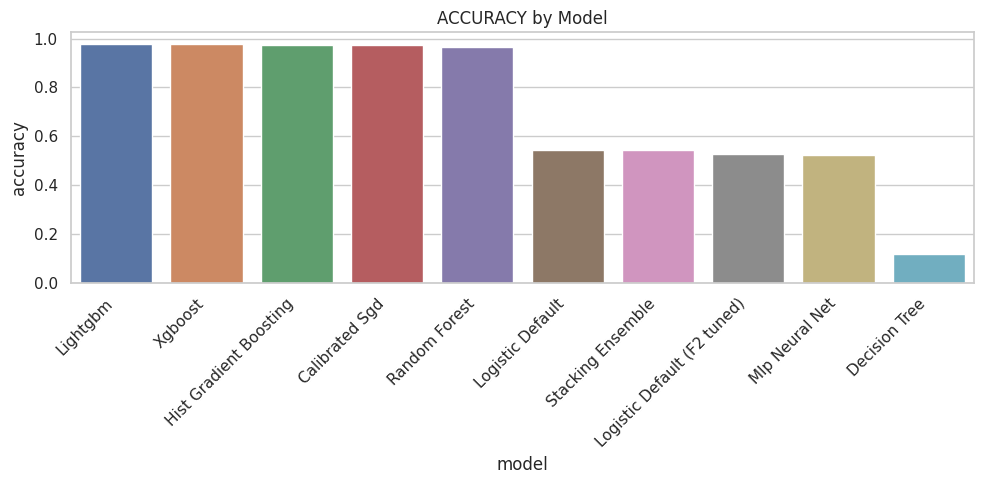

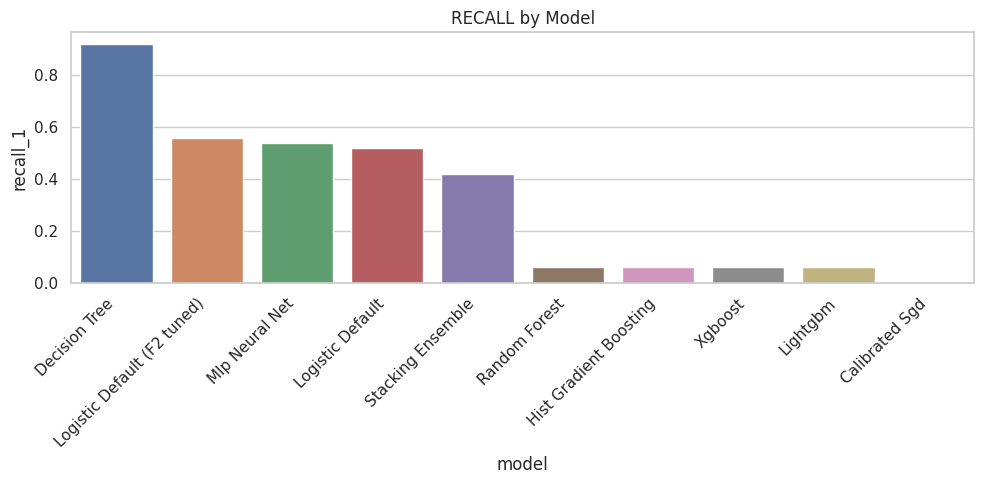

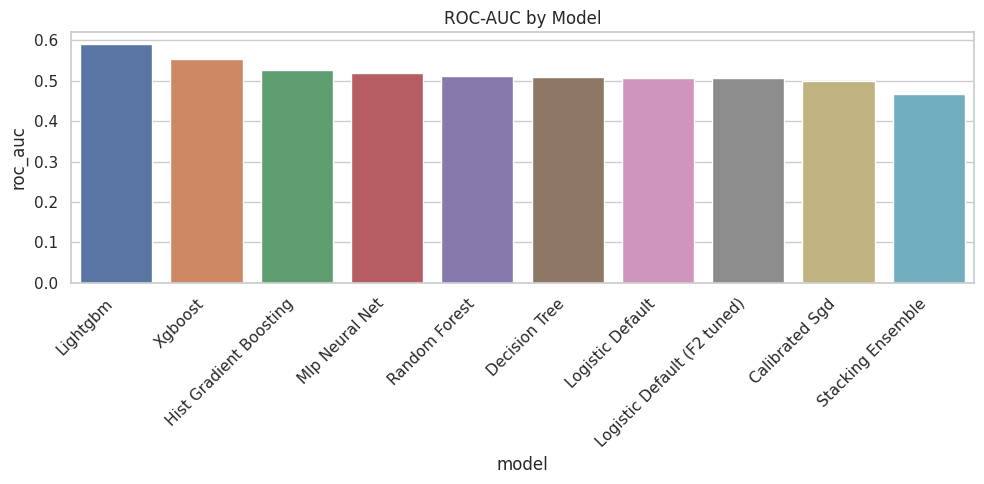

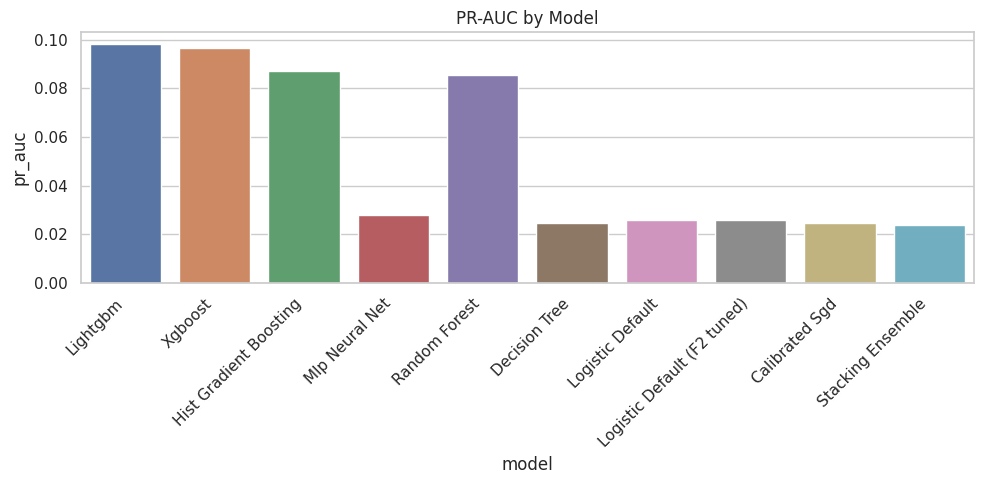

,model,threshold,accuracy,roc_auc,pr_auc,recall_1
0,Logistic Default,0.500000,0.545100,0.507916,0.025665,0.52
1,Decision Tree,0.500000,0.116041,0.507976,0.024764,0.92
2,Random Forest,0.500000,0.964895,0.512634,0.085472,0.06
3,Hist Gradient Boosting,0.500000,0.975622,0.526327,0.087054,0.06
4,Mlp Neural Net,0.500000,0.523159,0.518031,0.028038,0.54
5,Xgboost,0.500000,0.976597,0.554353,0.096741,0.06
6,Lightgbm,0.500000,0.977084,0.590195,0.098128,0.06
7,Calibrated Sgd,0.500000,0.975622,0.500000,0.024378,0.00
8,Stacking Ensemble,0.500000,0.543150,0.466467,0.023610,0.42
9,Logistic Default (F2 tuned),0.496225,0.527548,0.507916,0.025665,0.56


In [13]:
def print_metrics(label, y_true, y_pred, y_proba):
    print(f"\n{label} Results:")
    print(classification_report(y_true, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
    print(f"ROC-AUC: {roc_auc_score(y_true, y_proba):.3f}")
    print(f"PR-AUC: {average_precision_score(y_true, y_proba):.3f}")

# -----------------------------
# Evaluate ALL models (including logistic) at 0.5 threshold
# and also keep the F2-tuned logistic as a special row
# -----------------------------

summary_rows = []  # to build a comparison table

for name, model in model_registry.items():
    if model is None:
        continue

    # Get probabilities
    if hasattr(model, "predict_proba"):
        proba = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, "decision_function"):
        decision = model.decision_function(X_test)
        proba = 1.0 / (1.0 + np.exp(-decision))
    else:
        proba = model.predict(X_test)

    # Default 0.5 threshold
    preds = (proba >= 0.5).astype(int)

    pretty_name = name.replace("_", " ").title()
    print_metrics(f"{pretty_name} (0.5 threshold)", y_test, preds, proba)

    # Collect summary metrics
    cm = confusion_matrix(y_test, preds)
    tp = cm[1, 1]
    pos_total = max(1, (y_test == 1).sum())
    recall_1 = tp / pos_total

    summary_rows.append({
        "model": pretty_name,
        "threshold": 0.5,
        "accuracy": accuracy_score(y_test, preds),
        "roc_auc": roc_auc_score(y_test, proba),
        "pr_auc": average_precision_score(y_test, proba),
        "recall_1": recall_1,
    })

# -----------------------------
# Additional: F2-tuned logistic regression row
# -----------------------------

# Only if logistic_default is available
if "logistic_default" in model_registry and model_registry["logistic_default"] is not None:
    log_model = model_registry["logistic_default"]
    y_proba_log = log_model.predict_proba(X_test)[:, 1]

    precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba_log)
    beta = 2.0
    beta_sq = beta ** 2
    fbeta_scores = ((1 + beta_sq) * precisions[:-1] * recalls[:-1]) / np.where(
        (beta_sq * precisions[:-1] + recalls[:-1]) == 0,
        np.nan,
        (beta_sq * precisions[:-1] + recalls[:-1]),
    )
    best_idx = np.nanargmax(fbeta_scores)
    best_threshold = thresholds[best_idx]

    y_pred_log_tuned = (y_proba_log >= best_threshold).astype(int)

    print(f"\nBest logistic threshold (F2-max): {best_threshold:.3f} with F2={fbeta_scores[best_idx]:.3f}")
    print_metrics("Logistic Regression (F2 tuned)", y_test, y_pred_log_tuned, y_proba_log)

    cm_tuned = confusion_matrix(y_test, y_pred_log_tuned)
    tp_tuned = cm_tuned[1, 1]
    pos_total_tuned = max(1, (y_test == 1).sum())
    recall_1_tuned = tp_tuned / pos_total_tuned

    summary_rows.append({
        "model": "Logistic Default (F2 tuned)",
        "threshold": float(best_threshold),
        "accuracy": accuracy_score(y_test, y_pred_log_tuned),
        "roc_auc": roc_auc_score(y_test, y_proba_log),
        "pr_auc": average_precision_score(y_test, y_proba_log),
        "recall_1": recall_1_tuned,
    })

# -----------------------------
# Summary comparison table
# -----------------------------

summary_df = pd.DataFrame(summary_rows)
print("\n=== Model Comparison Summary ===")
display(summary_df.sort_values("roc_auc", ascending=False))

# Simple visual comparison of ROC-AUC and PR-AUC
plt.figure(figsize=(10, 5))
order = summary_df.sort_values("accuracy", ascending=False)["model"]
sns.barplot(data=summary_df, x="model", y="accuracy", order=order)
plt.xticks(rotation=45, ha="right")
plt.title("ACCURACY by Model")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
order = summary_df.sort_values("recall_1", ascending=False)["model"]
sns.barplot(data=summary_df, x="model", y="recall_1", order=order)
plt.xticks(rotation=45, ha="right")
plt.title("RECALL by Model")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
order = summary_df.sort_values("roc_auc", ascending=False)["model"]
sns.barplot(data=summary_df, x="model", y="roc_auc", order=order)
plt.xticks(rotation=45, ha="right")
plt.title("ROC-AUC by Model")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
sns.barplot(data=summary_df, x="model", y="pr_auc", order=order)
plt.xticks(rotation=45, ha="right")
plt.title("PR-AUC by Model")
plt.tight_layout()
plt.show()

summary_df

In [14]:
# === CLV-weighted churn scoring at user level ===

candidate_order = [
    "hist_gradient_boosting",
    "lightgbm",
    "xgboost",
    "random_forest",
    "logistic_default",
    "calibrated_sgd",
]

best_model = None
best_model_name = None
for name in candidate_order:
    model = model_registry.get(name)
    if model is not None:
        best_model_name = name
        best_model = model
        break

if best_model is None:
    raise RuntimeError("No available churn model found in model_registry for CLV-weighted scoring.")

print("Using model for CLV-weighted churn scoring:", best_model_name)

X_full = user_activity_churn[numeric_cols].copy()

if hasattr(best_model, "predict_proba"):
    churn_proba_all = best_model.predict_proba(X_full)[:, 1]
elif hasattr(best_model, "decision_function"):
    decision = best_model.decision_function(X_full)
    churn_proba_all = 1.0 / (1.0 + np.exp(-decision))
else:
    churn_proba_all = best_model.predict(X_full)

churn_scored = user_activity_churn[["user_id", "churn"]].copy()
churn_scored["churn_proba"] = churn_proba_all

print("churn_scored shape:", churn_scored.shape)
churn_scored.head()

Using model for CLV-weighted churn scoring: hist_gradient_boosting
churn_scored shape: (10253, 3)


,user_id,churn,churn_proba
0,user_00001,0,0.000238
1,user_00002,0,0.024474
2,user_00003,1,0.009875
3,user_00004,0,0.012294
4,user_00005,0,0.047071


In [15]:
# === Attach CLV features and compute expected value loss ===

financial_cols = [
    "cumulative_revenue",
    "clv_baseline",
    "tenure_days",
    "months_active",
    "monthly_spend",
]
financial_cols_present = [c for c in financial_cols if c in user_features.columns]

clv_df = user_features[["user_id"] + financial_cols_present].copy()

churn_scored = churn_scored.merge(clv_df, on="user_id", how="left")

if "clv_baseline" not in churn_scored.columns:
    churn_scored["clv_baseline"] = np.nan

churn_scored["clv_baseline"] = churn_scored["clv_baseline"].fillna(
    churn_scored.get("cumulative_revenue")
)

if "months_active" in churn_scored.columns:
    approx_clv = churn_scored.get("monthly_spend", 0) * churn_scored["months_active"].fillna(0)
else:
    approx_clv = churn_scored.get("monthly_spend", 0) * (
        churn_scored.get("tenure_days", 0) / 30.0
    )

churn_scored["clv_baseline"] = churn_scored["clv_baseline"].fillna(approx_clv)
churn_scored["clv_baseline"] = churn_scored["clv_baseline"].fillna(0)

churn_scored["expected_value_loss"] = churn_scored["clv_baseline"] * churn_scored["churn_proba"]

churn_scored["clv_band"] = pd.qcut(
    churn_scored["clv_baseline"].replace(0, np.nan).fillna(0),
    q=3,
    labels=["low", "medium", "high"],
    duplicates="drop",
)
churn_scored["churn_risk_band"] = pd.qcut(
    churn_scored["churn_proba"],
    q=3,
    labels=["low", "medium", "high"],
    duplicates="drop",
)

churn_scored["priority_segment"] = np.where(
    (churn_scored["clv_band"] == "high") & (churn_scored["churn_risk_band"] == "high"),
    "High CLV / High Churn",
    "Other",
)

print("CLV-weighted churn frame shape:", churn_scored.shape)
churn_scored.head()

CLV-weighted churn frame shape: (10855, 12)


,user_id,churn,churn_proba,cumulative_revenue,clv_baseline,tenure_days,months_active,monthly_spend,expected_value_loss,clv_band,churn_risk_band,priority_segment
0,user_00001,0,0.000238,538.496000,538.496000,448,14.933333,36.06,0.128045,high,low,Other
1,user_00002,0,0.024474,195.506000,195.506000,402,13.400000,14.59,4.784755,medium,high,Other
2,user_00003,1,0.009875,252.545667,252.545667,647,21.566667,11.71,2.493867,medium,medium,Other
3,user_00004,0,0.012294,297.976000,297.976000,313,10.433333,28.56,3.663416,medium,medium,Other
4,user_00005,0,0.047071,77.910000,77.910000,245,8.166667,9.54,3.667328,low,high,Other


In [16]:
# === Join churn + segmentation: cluster-wise churn & value loss ===

print("churn_scored columns:", list(churn_scored.columns))

segmentation_with_id = segmentation_df.copy()
if segmentation_with_id.index.name == "user_id":
    segmentation_with_id = segmentation_with_id.reset_index()

# Drop any overlapping join columns (except user_id) from the left side to avoid _x/_y suffixes
desired_join_cols = [
    "user_id",
    "churn",
    "churn_proba",
    "clv_baseline",
    "expected_value_loss",
    "clv_band",
    "churn_risk_band",
    "priority_segment",
]
left_overlap = (set(segmentation_with_id.columns) & set(desired_join_cols)) - {"user_id"}
if left_overlap:
    print("Dropping overlapping columns from segmentation before merge:", left_overlap)
    segmentation_with_id = segmentation_with_id.drop(columns=list(left_overlap))

available_join_cols = [c for c in desired_join_cols if c in churn_scored.columns]
print("Using join columns from churn_scored:", available_join_cols)

segmentation_enriched = segmentation_with_id.merge(
    churn_scored[available_join_cols],
    on="user_id",
    how="left",
)

agg_dict = {
    "users_in_cluster": ("user_id", "nunique"),
    "churn_rate": ("churn", "mean"),
    "avg_churn_proba": ("churn_proba", "mean"),
    "avg_clv": ("clv_baseline", "mean"),
}

if "expected_value_loss" in segmentation_enriched.columns:
    agg_dict["total_expected_value_loss"] = ("expected_value_loss", "sum")

cluster_churn_summary = segmentation_enriched.groupby("cluster").agg(**agg_dict).reset_index()

print("Cluster-level churn & CLV summary:")
cluster_churn_summary

churn_scored columns: ['user_id', 'churn', 'churn_proba', 'cumulative_revenue', 'clv_baseline', 'tenure_days', 'months_active', 'monthly_spend', 'expected_value_loss', 'clv_band', 'churn_risk_band', 'priority_segment']
Dropping overlapping columns from segmentation before merge: {'clv_baseline'}
Using join columns from churn_scored: ['user_id', 'churn', 'churn_proba', 'clv_baseline', 'expected_value_loss', 'clv_band', 'churn_risk_band', 'priority_segment']
Cluster-level churn & CLV summary:


,cluster,users_in_cluster,churn_rate,avg_churn_proba,avg_clv,total_expected_value_loss
0,0,3561,0.004901,0.023817,337.591096,26288.656630
1,1,6439,0.031779,0.046795,363.398434,104141.827207


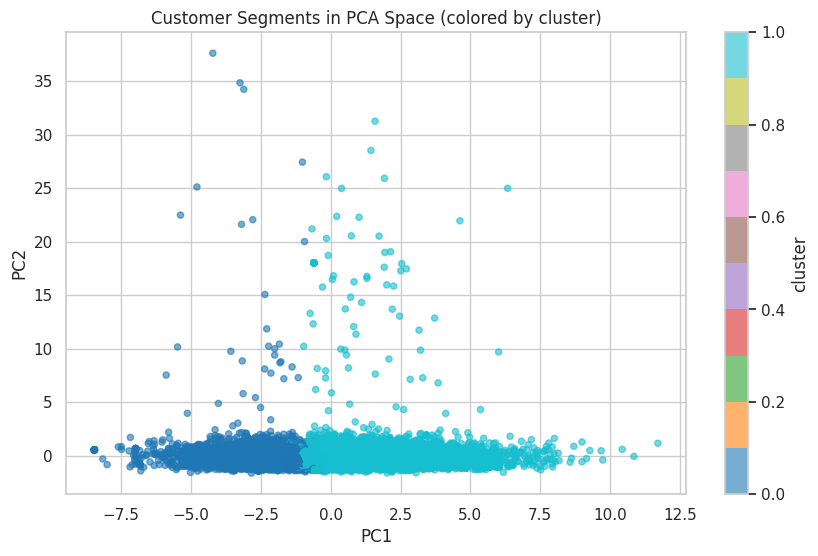

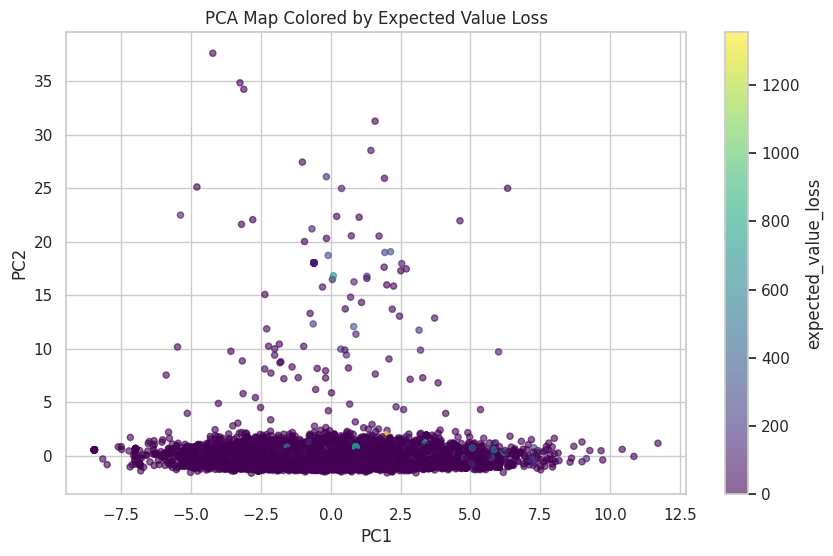

Explained variance by PCs: [0.11899074 0.05766631]


In [17]:
# === PCA & visualizations on enriched segmentation matrix ===

pca = PCA(n_components=2, random_state=42)
segmentation_pca = pca.fit_transform(segmentation_scaled)

pca_df = pd.DataFrame(
    segmentation_pca,
    columns=["pc1", "pc2"],
    index=segmentation_matrix.index,
)

pca_df = pca_df.join(segmentation_df[["cluster"]], how="left")
pca_df = pca_df.reset_index().rename(columns={"index": "user_id"})

pca_df = pca_df.merge(
    churn_scored[["user_id", "churn_proba", "expected_value_loss", "clv_baseline"]],
    on="user_id",
    how="left",
)

plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    pca_df["pc1"],
    pca_df["pc2"],
    c=pca_df["cluster"],
    cmap="tab10",
    alpha=0.6,
    s=20,
)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Customer Segments in PCA Space (colored by cluster)")
plt.colorbar(scatter, label="cluster")
plt.show()

plt.figure(figsize=(10, 6))
clv_risk = pca_df["expected_value_loss"].fillna(0)
scatter2 = plt.scatter(
    pca_df["pc1"],
    pca_df["pc2"],
    c=clv_risk,
    cmap="viridis",
    alpha=0.6,
    s=20,
)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA Map Colored by Expected Value Loss")
plt.colorbar(scatter2, label="expected_value_loss")
plt.show()

print("Explained variance by PCs:", pca.explained_variance_ratio_)

In [18]:
# === Recommendation System: Ratings preparation ===

# Use user ratings from the reviews table as the canonical source
ratings_df = reviews[["user_id", "movie_id", "rating"]].dropna().copy()

print("Ratings shape:", ratings_df.shape)
print("Unique users:", ratings_df["user_id"].nunique())
print("Unique movies:", ratings_df["movie_id"].nunique())

# Basic sanity check: distribution of ratings
print("\nRating distribution:")
print(ratings_df["rating"].value_counts().sort_index())

Ratings shape: (15450, 3)
Unique users: 7761
Unique movies: 1000

Rating distribution:
rating
1     776
2    1520
3    3824
4    5373
5    3957
Name: count, dtype: int64


In [19]:
# === Surprise Dataset + Model Definitions ===

from surprise import Dataset, Reader
from surprise import BaselineOnly, KNNBasic, KNNWithMeans, SVD
from surprise.model_selection import train_test_split as surprise_split
from surprise import accuracy

# Define rating scale from data (e.g. 1–5)
reader = Reader(rating_scale=(ratings_df["rating"].min(), ratings_df["rating"].max()))

data = Dataset.load_from_df(
    ratings_df[["user_id", "movie_id", "rating"]],
    reader
)

trainset, testset = surprise_split(data, test_size=0.2, random_state=42)

# 1) Baseline (user & item biases)
baseline = BaselineOnly()

# 2) User-based KNN
user_knn = KNNBasic(sim_options={"name": "cosine", "user_based": True})

# 3) Item-based KNN
item_knn = KNNBasic(sim_options={"name": "cosine", "user_based": False})

# 4) Item-based KNNWithMeans (often good for top-N)
item_knn_means = KNNWithMeans(sim_options={"name": "cosine", "user_based": False})

# 5) SVD (matrix factorization)
svd_model = SVD(n_factors=50, n_epochs=30, random_state=42)

rec_models = [
    ("BaselineOnly", baseline),
    ("UserKNN", user_knn),
    ("ItemKNN", item_knn),
    ("ItemKNNWithMeans", item_knn_means),
    ("SVD", svd_model),
]

In [20]:
# === Evaluation: RMSE/MAE and ranking metrics (Precision@k, Recall@k, NDCG@k) ===

import numpy as np

def precision_at_k(predictions, k=10, threshold=3.5):
    user_pred = {}
    for uid, iid, true_r, est, _ in predictions:
        user_pred.setdefault(uid, []).append((est, true_r))

    precisions = []
    for uid, preds in user_pred.items():
        preds = sorted(preds, key=lambda x: x[0], reverse=True)
        top_k = preds[:k]
        relevant = sum((true >= threshold) for _, true in top_k)
        precisions.append(relevant / k)

    return float(np.mean(precisions)) if precisions else 0.0


def recall_at_k(predictions, k=10, threshold=3.5):
    user_pred = {}
    for uid, iid, true_r, est, _ in predictions:
        user_pred.setdefault(uid, []).append((est, true_r))

    recalls = []
    for uid, preds in user_pred.items():
        total_relevant = sum((true >= threshold) for _, true in preds)
        if total_relevant == 0:
            continue

        preds = sorted(preds, key=lambda x: x[0], reverse=True)
        top_k = preds[:k]
        retrieved_relevant = sum((true >= threshold) for _, true in top_k)
        recalls.append(retrieved_relevant / total_relevant)

    return float(np.mean(recalls)) if recalls else 0.0


def ndcg_at_k(predictions, k=10):
    user_pred = {}
    for uid, iid, true_r, est, _ in predictions:
        user_pred.setdefault(uid, []).append((est, true_r))

    ndcgs = []
    for uid, preds in user_pred.items():
        preds = sorted(preds, key=lambda x: x[0], reverse=True)
        top_k = preds[:k]

        dcg = sum((true / np.log2(idx + 2)) for idx, (_, true) in enumerate(top_k))

        ideal = sorted(preds, key=lambda x: x[1], reverse=True)[:k]
        idcg = sum((true / np.log2(idx + 2)) for idx, (_, true) in enumerate(ideal))

        if idcg == 0:
            continue
        ndcgs.append(dcg / idcg)

    return float(np.mean(ndcgs)) if ndcgs else 0.0


results = []

for name, algo in rec_models:
    print(f"\nTraining {name}...")
    algo.fit(trainset)
    preds = algo.test(testset)

    rmse = accuracy.rmse(preds, verbose=False)
    mae = accuracy.mae(preds, verbose=False)

    p10 = precision_at_k(preds, k=10, threshold=3.5)
    r10 = recall_at_k(preds, k=10, threshold=3.5)
    ndcg10 = ndcg_at_k(preds, k=10)

    results.append([name, rmse, mae, p10, r10, ndcg10])

results_df = pd.DataFrame(
    results,
    columns=["Model", "RMSE", "MAE", "Precision@10", "Recall@10", "NDCG@10"]
)

print("\n=== Recommendation Model Comparison ===")
display(results_df.sort_values("NDCG@10", ascending=False))

# Choose a final model for serving recommendations (e.g., best NDCG@10)
best_name = results_df.sort_values("NDCG@10", ascending=False)["Model"].iloc[0]
best_model = dict(rec_models)[best_name]
print(f"\nSelected recommendation model for production: {best_name}")


Training BaselineOnly...
Estimating biases using als...

Training UserKNN...
Computing the cosine similarity matrix...
Done computing similarity matrix.

Training ItemKNN...
Computing the cosine similarity matrix...
Done computing similarity matrix.

Training ItemKNNWithMeans...
Computing the cosine similarity matrix...
Done computing similarity matrix.

Training SVD...

=== Recommendation Model Comparison ===


,Model,RMSE,MAE,Precision@10,Recall@10,NDCG@10
3,ItemKNNWithMeans,1.117130,0.906452,0.07213,1.0,0.994820
2,ItemKNN,1.085458,0.893350,0.07213,1.0,0.994675
4,SVD,1.113884,0.911079,0.07213,1.0,0.994543
1,UserKNN,1.103157,0.914387,0.07213,1.0,0.994513
0,BaselineOnly,1.102796,0.909327,0.07213,1.0,0.994314



Selected recommendation model for production: ItemKNNWithMeans


In [21]:
# === Train final recommendation model on full data & define top-N function ===

from surprise import KNNWithMeans

# Refit chosen model on full dataset (train on all ratings)
best_model.fit(data.build_full_trainset())

# Helper: get movies a user has already rated in the training data
def get_seen_items_surprise(trainset, raw_user_id):
    try:
        inner_uid = trainset.to_inner_uid(raw_user_id)
    except ValueError:
        return set()
    user_ratings = trainset.ur[inner_uid]
    seen_raw_ids = {trainset.to_raw_iid(inner_iid) for inner_iid, _ in user_ratings}
    return seen_raw_ids

full_trainset = data.build_full_trainset()

def recommend_top_n_for_user(user_id, n=10, min_pred_rating=3.5):
    """
    Recommend top-N movies for a user using the chosen Surprise model.
    user_id must match ids in ratings_df['user_id'].
    """
    # Items user already rated
    seen = get_seen_items_surprise(full_trainset, user_id)
    if not seen:
        print(f"User {user_id} has no ratings in the training data.")
        return pd.DataFrame()

    all_movies = ratings_df["movie_id"].unique()
    candidates = [iid for iid in all_movies if iid not in seen]

    preds = []
    for movie_id in candidates:
        est = best_model.predict(user_id, movie_id, verbose=False).est
        preds.append((movie_id, est))

    preds.sort(key=lambda x: x[1], reverse=True)
    preds = [p for p in preds if p[1] >= min_pred_rating]
    top = preds[:n]

    if not top:
        print("No movies found above the min_pred_rating threshold.")
        return pd.DataFrame()

    top_ids = [movie_id for movie_id, _ in top]
    rec_df = movies[movies["movie_id"].isin(top_ids)].copy()

    cols = [c for c in ["movie_id", "title", "genre_primary", "rating", "language"] if c in rec_df.columns]
    rec_df = rec_df[cols]

    pred_df = pd.DataFrame(top, columns=["movie_id", "predicted_rating"])
    rec_df = rec_df.merge(pred_df, on="movie_id", how="left")
    rec_df = rec_df.sort_values("predicted_rating", ascending=False).reset_index(drop=True)

    return rec_df

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [22]:
# === Example: show recommendations for a sample user ===

# Pick a user with at least a few ratings
user_counts = ratings_df["user_id"].value_counts()
valid_users = user_counts[user_counts >= 5].index.tolist()

if valid_users:
    sample_user = valid_users[0]
    print("Sample user:", sample_user)
    sample_recs = recommend_top_n_for_user(sample_user, n=10, min_pred_rating=3.5)
    display(sample_recs)
else:
    print("No users with enough ratings to demonstrate recommendations.")

Sample user: user_05784


,movie_id,title,genre_primary,rating,language,predicted_rating
0,movie_0047,Day Journey,Thriller,PG,English,5
1,movie_0342,Adventure Story,Biography,TV-Y7,English,5
2,movie_0452,Family Secret,Romance,TV-Y7,French,5
3,movie_0465,Battle Fire,Romance,R,Korean,5
4,movie_0568,Dark Legend,Sci-Fi,TV-Y7,English,5
5,movie_0666,Day City,Adventure,R,English,5
6,movie_0723,House Day,Thriller,TV-MA,Hindi,5
7,movie_0783,Love Journey,Horror,TV-G,Hindi,5
8,movie_0796,Bright Mystery,War,TV-14,English,5
9,movie_0853,Family Journey,Fantasy,TV-Y,French,5


Using lightgbm for SHAP explanations
Global SHAP summary (bar) for churn model features:


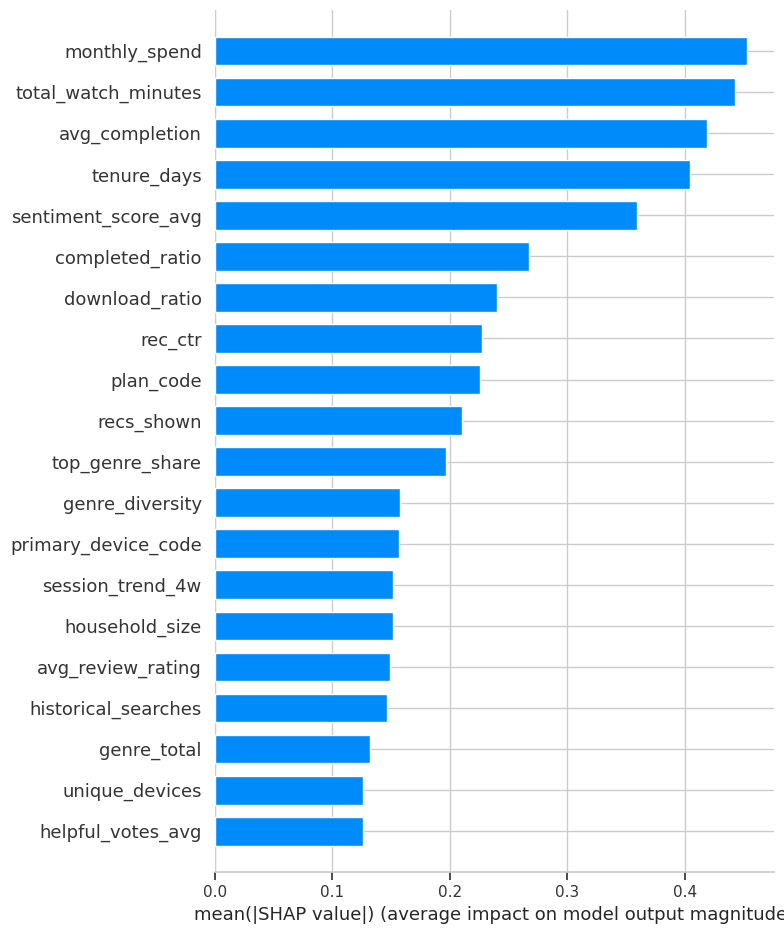

Global SHAP summary (beeswarm) for churn model features:


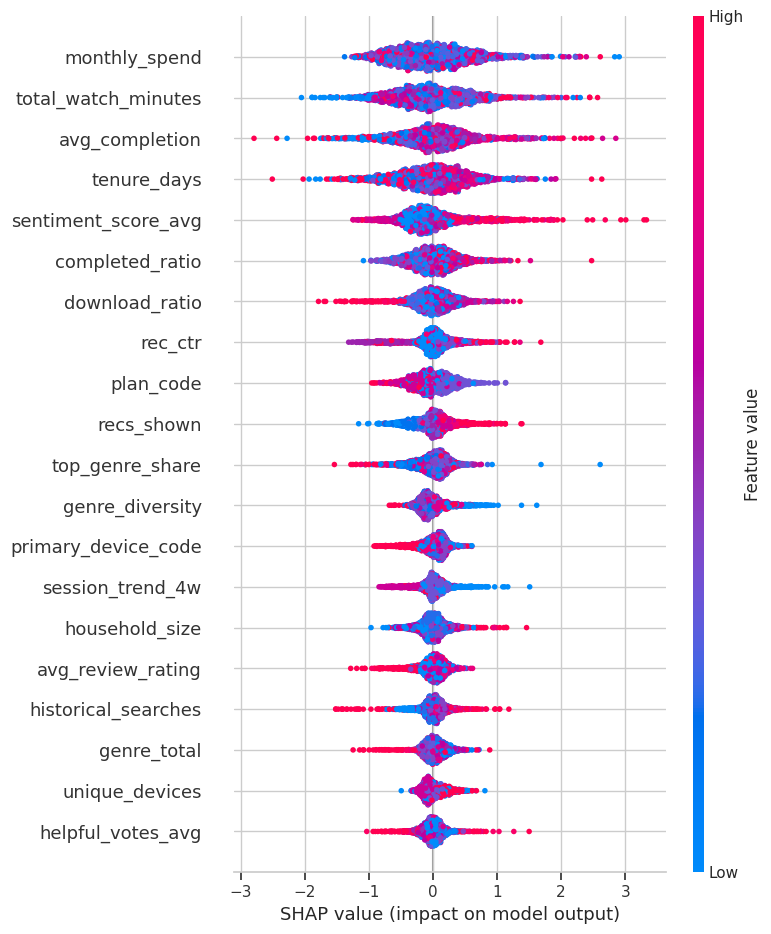

In [23]:
# === SHAP Explainability for Churn Model ===

# Choose a primary model for SHAP (tree-based preferred)
shap_candidate_order = [
    "lightgbm",
    "xgboost",
    "hist_gradient_boosting",
    "random_forest",
]

shap_model = None
shap_model_name = None
for name in shap_candidate_order:
    m = model_registry.get(name)
    if m is not None:
        shap_model = m
        shap_model_name = name
        break

if shap_model is None:
    # Fallback: use logistic regression
    shap_model = model_registry["logistic_default"]
    shap_model_name = "logistic_default"

print(f"Using {shap_model_name} for SHAP explanations")

# Use the same feature matrix as for modeling (X)
X_background = X_train.sample(n=min(1000, len(X_train)), random_state=42)
X_explain = X_train.sample(n=min(2000, len(X_train)), random_state=42)

# TreeExplainer works well for tree-based models; KernelExplainer would be slower
if shap_model_name in ["random_forest", "hist_gradient_boosting", "xgboost", "lightgbm"]:
    explainer = shap.TreeExplainer(shap_model)
    shap_values = explainer.shap_values(X_explain)
else:
    # Fallback to KernelExplainer for non-tree models
    explainer = shap.KernelExplainer(shap_model.predict_proba, X_background)
    shap_values = explainer.shap_values(X_explain, nsamples=100)

# For binary classifiers, shap_values may be a list [class0, class1]
if isinstance(shap_values, list) and len(shap_values) == 2:
    shap_values_pos = shap_values[1]
else:
    shap_values_pos = shap_values

print("Global SHAP summary (bar) for churn model features:")
shap.summary_plot(shap_values_pos, X_explain, feature_names=X_explain.columns, plot_type="bar")

print("Global SHAP summary (beeswarm) for churn model features:")
shap.summary_plot(shap_values_pos, X_explain, feature_names=X_explain.columns)


In [24]:
# === SHAP Local Explanations for Individual Users ===

# Keep references for later cells
shap_explainer = explainer
shap_values_global = shap_values_pos

feature_cols_churn = X.columns.tolist()

def explain_user_churn(user_id, top_n=15):
    """Print top contributing features for a single user's churn prediction using SHAP."""
    # Align to the same feature set used for modeling (numeric_cols in user_activity_churn)
    row = user_activity_churn[user_activity_churn["user_id"] == user_id]
    if row.empty:
        print(f"User {user_id} not found in user_activity_churn.")
        return

    X_row = row[feature_cols_churn]

    # Compute SHAP values for this one row
    sv = shap_explainer.shap_values(X_row)
    if isinstance(sv, list) and len(sv) == 2:
        sv_pos = sv[1][0]
    else:
        sv_pos = sv[0]

    contrib_df = pd.DataFrame({
        "feature": feature_cols_churn,
        "feature_value": X_row.iloc[0].values,
        "shap_value": sv_pos,
    })
    contrib_df["abs_shap"] = contrib_df["shap_value"].abs()
    contrib_df = contrib_df.sort_values("abs_shap", ascending=False).head(top_n)

    print(f"Top {top_n} SHAP feature contributions for user {user_id} (positive = pushes towards churn):")
    display(contrib_df[["feature", "feature_value", "shap_value"]])

    # Optional: waterfall plot if supported
    try:
        shap.plots._waterfall.waterfall_legacy(
            shap.Explanation(
                values=sv_pos,
                base_values=shap_explainer.expected_value[1] if isinstance(shap_explainer.expected_value, (list, np.ndarray)) else shap_explainer.expected_value,
                data=X_row.iloc[0].values,
                feature_names=feature_cols_churn,
            )
        )
    except Exception:
        pass

# Example: explain a churn prediction for one sample user
sample_user_for_shap = user_activity_churn["user_id"].iloc[0]
explain_user_churn(sample_user_for_shap, top_n=15)


Top 15 SHAP feature contributions for user user_00001 (positive = pushes towards churn):


,feature,feature_value,shap_value
6,total_watch_minutes,760.600000,-0.647987
9,completed_ratio,0.636364,-0.511768
27,historical_sessions,11.000000,-0.388790
1,household_size,1.000000,-0.342266
10,download_ratio,0.454545,-0.252609
0,monthly_spend,36.060000,-0.184502
17,rec_ctr,0.000000,-0.164579
26,top_genre_share,0.250000,0.155279
8,unique_devices,4.000000,-0.148217
3,plan_code,0.000000,-0.146253


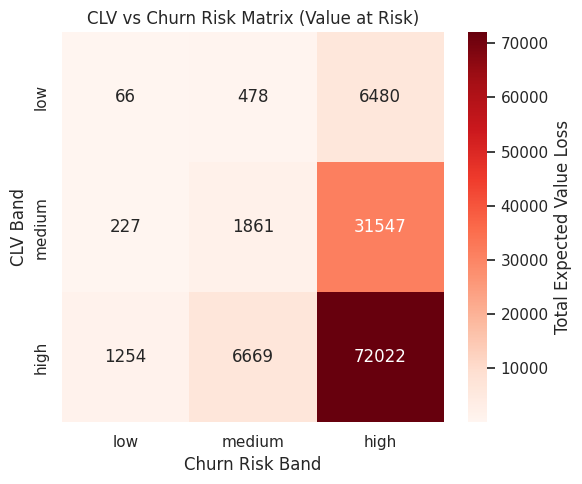

churn_risk_band,low,medium,high
clv_band,,,
low,66.376960,478.352005,6480.409947
medium,227.000493,1860.713782,31546.562958
high,1253.845586,6668.849564,72022.460309


In [25]:
# === Business Visual 1: CLV vs Churn Risk Heatmap (Value at Risk) ===

# Aggregate expected value loss by CLV band and churn risk band
clv_churn_matrix = (
    churn_scored
    .groupby(["clv_band", "churn_risk_band"])["expected_value_loss"]
    .sum()
    .unstack("churn_risk_band")
)

# Ensure a consistent ordering of bands
band_order = ["low", "medium", "high"]
clv_churn_matrix = clv_churn_matrix.reindex(index=band_order, columns=band_order)

plt.figure(figsize=(6, 5))
sns.heatmap(
    clv_churn_matrix,
    annot=True,
    fmt=".0f",
    cmap="Reds",
    cbar_kws={"label": "Total Expected Value Loss"},
)
plt.xlabel("Churn Risk Band")
plt.ylabel("CLV Band")
plt.title("CLV vs Churn Risk Matrix (Value at Risk)")
plt.tight_layout()
plt.show()

clv_churn_matrix


In [26]:
# === Business Visual 2: Cluster Personas Table ===

# Build a cluster-level summary with key business features
# Join segmentation (with clusters) to user_features for richer attributes
seg_with_features = segmentation_df.reset_index().merge(
    user_features,
    on="user_id",
    how="left",
    suffixes=("_seg", ""),
)

# Merge churn + CLV summary to bring in churn_rate and value loss
cluster_summary = cluster_churn_summary.set_index("cluster")

persona_metrics = seg_with_features.groupby("cluster").agg(
    avg_tenure_days=("tenure_days", "mean"),
    avg_monthly_spend=("monthly_spend", "mean"),
    avg_total_watch_hours=("total_watch_hours", "mean"),
    avg_completion_ratio=("completion_ratio", "mean"),
    avg_search_frequency=("search_frequency", "mean"),
    avg_rec_ctr=("rec_ctr", "mean"),
    avg_review_rating=("avg_review_rating", "mean"),
    avg_sentiment_score=("sentiment_score_avg", "mean"),
    avg_kids_share=("kids_content_share", "mean"),
).join(cluster_summary, how="left")

# Derive simple textual personas based on relative metrics
# Compute global means for comparison
global_means = persona_metrics.mean()

def describe_cluster(row):
    spend_level = "high" if row["avg_monthly_spend"] > global_means["avg_monthly_spend"] else "low/medium"
    engagement_level = "high" if row["avg_total_watch_hours"] > global_means["avg_total_watch_hours"] else "low/medium"
    churn_level = "high" if row["churn_rate"] > global_means["churn_rate"] else "low/medium"
    kids_focus = "family / kids-heavy" if row["avg_kids_share"] > global_means["avg_kids_share"] else "general audience"

    return (
        f"{spend_level.capitalize()}-spend, {engagement_level}-engagement, {kids_focus} users; "
        f"churn rate {row['churn_rate']:.1%}, avg CLV {row['avg_clv']:.0f}, "
        f"value at risk {row.get('total_expected_value_loss', 0):.0f}."
    )

persona_metrics["persona_summary"] = persona_metrics.apply(describe_cluster, axis=1)

# Reorder columns for readability
cluster_personas = persona_metrics.reset_index()[[
    "cluster",
    "users_in_cluster",
    "churn_rate",
    "avg_clv",
    "total_expected_value_loss",
    "avg_monthly_spend",
    "avg_total_watch_hours",
    "avg_completion_ratio",
    "avg_search_frequency",
    "avg_review_rating",
    "avg_sentiment_score",
    "avg_kids_share",
    "persona_summary",
]]

print("Cluster Personas (numeric profile + narrative summary):")
display(cluster_personas)


Cluster Personas (numeric profile + narrative summary):


,cluster,users_in_cluster,churn_rate,avg_clv,total_expected_value_loss,avg_monthly_spend,avg_total_watch_hours,avg_completion_ratio,avg_search_frequency,avg_review_rating,avg_sentiment_score,avg_kids_share,persona_summary
0,0,3561,0.004901,337.591096,26288.656630,19.715705,15.851663,50.010936,0.003748,2.772001,0.444282,0.102936,"Low/medium-spend, high-engagement, general aud..."
1,1,6439,0.031779,363.398434,104141.827207,21.859282,8.677799,49.757664,-0.003635,2.860833,0.456071,0.103883,"High-spend, low/medium-engagement, family / ki..."


[LightGBM] [Info] Number of positive: 201, number of negative: 8001
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001265 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1714
[LightGBM] [Info] Number of data points in the train set: 8202, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.024506 -> initscore=-3.684017
[LightGBM] [Info] Start training from score -3.684017


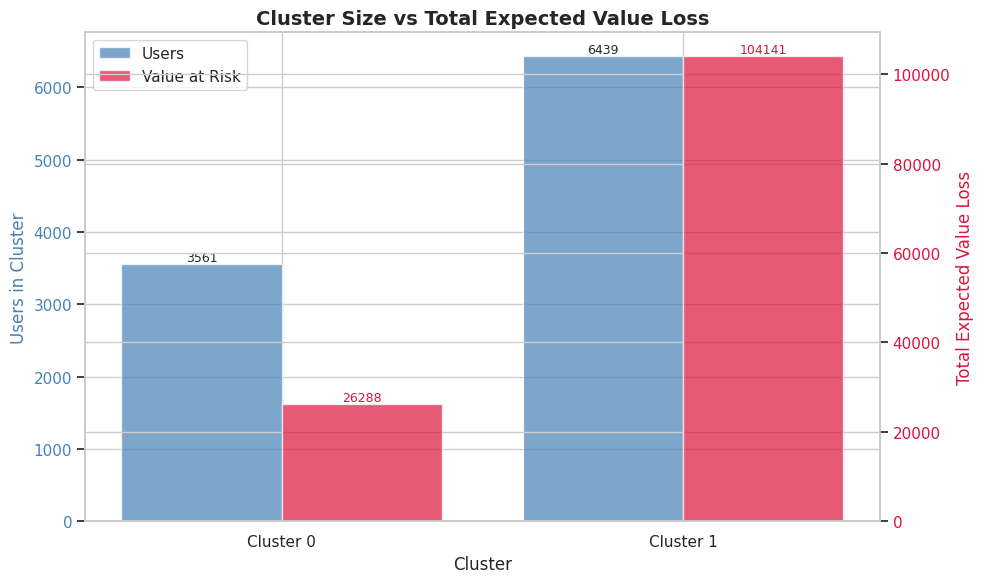

In [27]:
# === Segmentation Visual 1: Cluster Size vs Value at Risk (Dual-Axis Bar Chart) ===

fig, ax1 = plt.subplots(figsize=(10, 6))

clusters = cluster_churn_summary["cluster"].values
users_counts = cluster_churn_summary["users_in_cluster"].values
value_loss = cluster_churn_summary["total_expected_value_loss"].values

# Left axis: user count
color1 = "steelblue"
ax1.set_xlabel("Cluster", fontsize=12)
ax1.set_ylabel("Users in Cluster", color=color1, fontsize=12)
bars1 = ax1.bar(clusters - 0.2, users_counts, 0.4, label="Users", color=color1, alpha=0.7)
ax1.tick_params(axis="y", labelcolor=color1)

# Right axis: value at risk
ax2 = ax1.twinx()
color2 = "crimson"
ax2.set_ylabel("Total Expected Value Loss", color=color2, fontsize=12)
bars2 = ax2.bar(clusters + 0.2, value_loss, 0.4, label="Value at Risk", color=color2, alpha=0.7)
ax2.tick_params(axis="y", labelcolor=color2)

# Add value labels on bars
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2., height,
             f"{int(height)}", ha="center", va="bottom", fontsize=9)

for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2., height,
             f"{int(height)}", ha="center", va="bottom", fontsize=9, color=color2)

plt.title("Cluster Size vs Total Expected Value Loss", fontsize=14, fontweight="bold")
ax1.set_xticks(clusters)
ax1.set_xticklabels([f"Cluster {c}" for c in clusters])

# Legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper left")

plt.tight_layout()
plt.show()


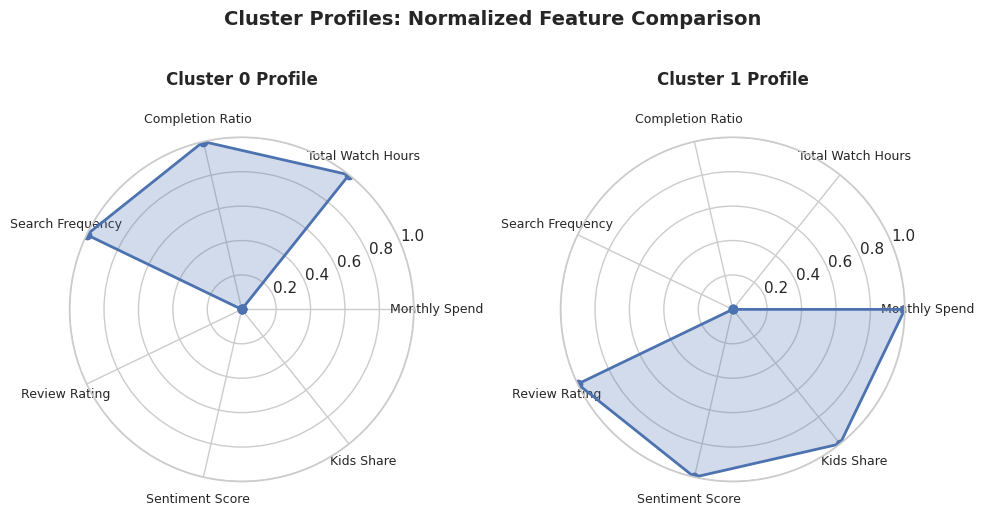

In [28]:
# === Segmentation Visual 2: Radar (Spider) Plots for Key Clusters ===

from math import pi

# Select key metrics to compare across clusters (normalize to 0-1 scale for radar)
radar_metrics = [
    "avg_monthly_spend",
    "avg_total_watch_hours",
    "avg_completion_ratio",
    "avg_search_frequency",
    "avg_review_rating",
    "avg_sentiment_score",
    "avg_kids_share",
]

# Get cluster persona data (already computed in previous cell)
radar_data = persona_metrics[radar_metrics].copy()

# Normalize each metric to 0-1 scale (min-max normalization)
for col in radar_metrics:
    col_min = radar_data[col].min()
    col_max = radar_data[col].max()
    if col_max > col_min:
        radar_data[col] = (radar_data[col] - col_min) / (col_max - col_min)
    else:
        radar_data[col] = 0.5  # neutral if no variance

# Number of variables
N = len(radar_metrics)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]  # complete the circle

# Plot radar for top 2-3 clusters (or all if <= 3)
n_clusters = len(radar_data)
n_plot = min(3, n_clusters)

fig, axes = plt.subplots(1, n_plot, figsize=(5 * n_plot, 5), subplot_kw=dict(projection="polar"))

if n_plot == 1:
    axes = [axes]

for idx, cluster_id in enumerate(radar_data.index[:n_plot]):
    ax = axes[idx]
    values = radar_data.loc[cluster_id, radar_metrics].tolist()
    values += values[:1]  # complete the circle

    ax.plot(angles, values, "o-", linewidth=2, label=f"Cluster {cluster_id}")
    ax.fill(angles, values, alpha=0.25)

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels([m.replace("avg_", "").replace("_", " ").title() for m in radar_metrics], fontsize=9)
    ax.set_ylim(0, 1)
    ax.set_title(f"Cluster {cluster_id} Profile", size=12, fontweight="bold", pad=20)
    ax.grid(True)

plt.suptitle("Cluster Profiles: Normalized Feature Comparison", fontsize=14, fontweight="bold", y=1.02)
plt.tight_layout()
plt.show()


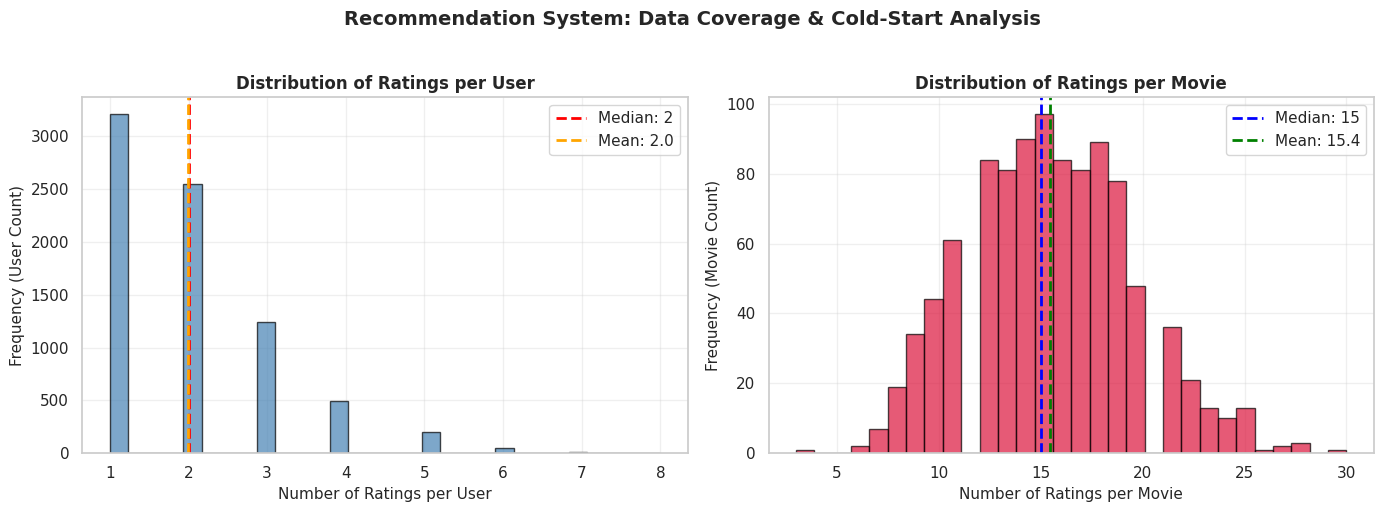

Coverage Statistics:
  Users with < 5 ratings (cold-start risk): 7489 (96.5%)
  Movies with < 5 ratings (cold-start risk): 1 (0.1%)
  Median ratings per user: 2
  Median ratings per movie: 15


In [29]:
# === Recommendation System Visual 1: Coverage & Cold-Start Insights ===

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Ratings per user distribution
user_rating_counts = ratings_df["user_id"].value_counts()
axes[0].hist(user_rating_counts, bins=30, edgecolor="black", alpha=0.7, color="steelblue")
axes[0].axvline(user_rating_counts.median(), color="red", linestyle="--", linewidth=2, label=f"Median: {user_rating_counts.median():.0f}")
axes[0].axvline(user_rating_counts.mean(), color="orange", linestyle="--", linewidth=2, label=f"Mean: {user_rating_counts.mean():.1f}")
axes[0].set_xlabel("Number of Ratings per User", fontsize=11)
axes[0].set_ylabel("Frequency (User Count)", fontsize=11)
axes[0].set_title("Distribution of Ratings per User", fontsize=12, fontweight="bold")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Right: Ratings per movie distribution
movie_rating_counts = ratings_df["movie_id"].value_counts()
axes[1].hist(movie_rating_counts, bins=30, edgecolor="black", alpha=0.7, color="crimson")
axes[1].axvline(movie_rating_counts.median(), color="blue", linestyle="--", linewidth=2, label=f"Median: {movie_rating_counts.median():.0f}")
axes[1].axvline(movie_rating_counts.mean(), color="green", linestyle="--", linewidth=2, label=f"Mean: {movie_rating_counts.mean():.1f}")
axes[1].set_xlabel("Number of Ratings per Movie", fontsize=11)
axes[1].set_ylabel("Frequency (Movie Count)", fontsize=11)
axes[1].set_title("Distribution of Ratings per Movie", fontsize=12, fontweight="bold")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.suptitle("Recommendation System: Data Coverage & Cold-Start Analysis", fontsize=14, fontweight="bold", y=1.02)
plt.tight_layout()
plt.show()

# Print summary stats
print("Coverage Statistics:")
print(f"  Users with < 5 ratings (cold-start risk): {(user_rating_counts < 5).sum()} ({(user_rating_counts < 5).mean() * 100:.1f}%)")
print(f"  Movies with < 5 ratings (cold-start risk): {(movie_rating_counts < 5).sum()} ({(movie_rating_counts < 5).mean() * 100:.1f}%)")
print(f"  Median ratings per user: {user_rating_counts.median():.0f}")
print(f"  Median ratings per movie: {movie_rating_counts.median():.0f}")


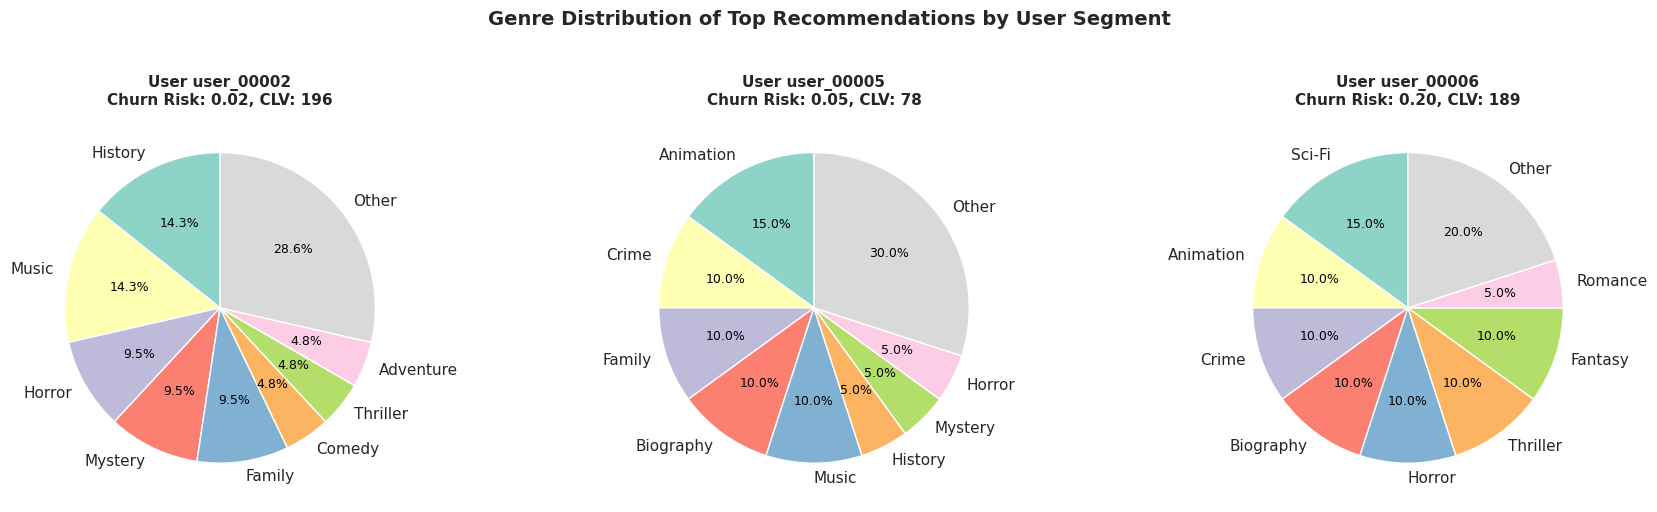


Sample User Recommendations Summary:


,user_id,n_recommendations,top_genre,avg_predicted_rating,churn_probability,clv_baseline
0,user_00002,21,History,4.942547,0.024474,195.506000
1,user_00005,20,Animation,4.378925,0.047071,77.910000
2,user_00006,20,Sci-Fi,4.334405,0.200340,188.873333


In [30]:
# === Recommendation System Visual 2: Genre Mix of Recommendations for Sample Users ===

# Select a few sample users: one high-risk, one low-risk, one medium
high_risk_users = churn_scored[churn_scored["churn_risk_band"] == "high"]["user_id"].head(3).tolist()
low_risk_users = churn_scored[churn_scored["churn_risk_band"] == "low"]["user_id"].head(3).tolist()

# Filter to users that exist in ratings_df
sample_users = []
for uid in high_risk_users + low_risk_users:
    if uid in ratings_df["user_id"].values:
        sample_users.append(uid)
        if len(sample_users) >= 3:
            break

if len(sample_users) < 3:
    # Fallback: use any valid users
    valid_users = ratings_df["user_id"].value_counts()[ratings_df["user_id"].value_counts() >= 5].index.tolist()
    sample_users = valid_users[:3]

n_samples = min(3, len(sample_users))
if n_samples > 0:
    fig, axes = plt.subplots(1, n_samples, figsize=(6 * n_samples, 5))
    if n_samples == 1:
        axes = [axes]

    for idx, user_id in enumerate(sample_users[:n_samples]):
        recs = recommend_top_n_for_user(user_id, n=20, min_pred_rating=3.0)
        
        if recs.empty:
            axes[idx].text(0.5, 0.5, f"No recommendations\nfor user {user_id}", 
                          ha="center", va="center", fontsize=12)
            axes[idx].set_title(f"User {user_id}", fontsize=11, fontweight="bold")
            continue

        # Get genre distribution of recommendations
        if "genre_primary" in recs.columns:
            genre_counts = recs["genre_primary"].value_counts()
            
            # Top 8 genres (or all if fewer)
            top_genres = genre_counts.head(8)
            other_count = genre_counts.iloc[8:].sum() if len(genre_counts) > 8 else 0
            
            if other_count > 0:
                top_genres["Other"] = other_count

            # Pie chart
            colors = plt.cm.Set3(range(len(top_genres)))
            wedges, texts, autotexts = axes[idx].pie(
                top_genres.values,
                labels=top_genres.index,
                autopct="%1.1f%%",
                startangle=90,
                colors=colors,
            )
            
            for autotext in autotexts:
                autotext.set_color("black")
                autotext.set_fontsize(9)

        # Get user's churn risk and CLV info
        user_info = churn_scored[churn_scored["user_id"] == user_id]
        if not user_info.empty:
            churn_prob = user_info["churn_proba"].iloc[0]
            clv = user_info["clv_baseline"].iloc[0]
            title = f"User {user_id}\nChurn Risk: {churn_prob:.2f}, CLV: {clv:.0f}"
        else:
            title = f"User {user_id}"

        axes[idx].set_title(title, fontsize=11, fontweight="bold")

    plt.suptitle("Genre Distribution of Top Recommendations by User Segment", 
                 fontsize=14, fontweight="bold", y=1.02)
    plt.tight_layout()
    plt.show()

    # Also show a table summary
    print("\nSample User Recommendations Summary:")
    summary_rows = []
    for user_id in sample_users[:n_samples]:
        recs = recommend_top_n_for_user(user_id, n=20, min_pred_rating=3.0)
        user_info = churn_scored[churn_scored["user_id"] == user_id]
        
        if not recs.empty and "genre_primary" in recs.columns:
            top_genre = recs["genre_primary"].mode().iloc[0] if len(recs["genre_primary"].mode()) > 0 else "N/A"
            avg_pred_rating = recs["predicted_rating"].mean()
        else:
            top_genre = "N/A"
            avg_pred_rating = 0.0

        churn_prob = user_info["churn_proba"].iloc[0] if not user_info.empty else 0.0
        clv = user_info["clv_baseline"].iloc[0] if not user_info.empty else 0.0

        summary_rows.append({
            "user_id": user_id,
            "n_recommendations": len(recs),
            "top_genre": top_genre,
            "avg_predicted_rating": avg_pred_rating,
            "churn_probability": churn_prob,
            "clv_baseline": clv,
        })

    if summary_rows:
        rec_summary_df = pd.DataFrame(summary_rows)
        display(rec_summary_df)
else:
    print("No valid users found for recommendation visualization.")


In [ ]:
# === Save Artifacts for Streamlit App ===

import pickle
import os

# Ensure results directory exists
os.makedirs(RESULTS_DIR, exist_ok=True)

# 1) Save dataframes as CSV
print("Saving dataframes...")
user_features.to_csv(os.path.join(RESULTS_DIR, "user_features.csv"), index=False)
churn_scored.to_csv(os.path.join(RESULTS_DIR, "churn_scored.csv"), index=False)
if 'cluster_personas' in locals():
    cluster_personas.to_csv(os.path.join(RESULTS_DIR, "cluster_personas.csv"), index=False)
print("✓ Dataframes saved")

# 2) Save best churn model
print("Saving churn model...")
best_model = model_registry.get(best_model_name) if 'best_model_name' in locals() else model_registry.get("hist_gradient_boosting")
if best_model is not None:
    with open(os.path.join(RESULTS_DIR, "best_churn_model.pkl"), "wb") as f:
        pickle.dump(best_model, f)
    print("✓ Churn model saved")
else:
    print("⚠ Churn model not found")

# 3) Save SHAP explainer (if available)
print("Saving SHAP explainer...")
if 'shap_explainer' in locals():
    with open(os.path.join(RESULTS_DIR, "shap_explainer.pkl"), "wb") as f:
        pickle.dump(shap_explainer, f)
    print("✓ SHAP explainer saved")
    
    # Also save feature columns list
    if 'feature_cols_churn' in locals():
        with open(os.path.join(RESULTS_DIR, "feature_columns.pkl"), "wb") as f:
            pickle.dump(feature_cols_churn, f)
        print("✓ Feature columns saved")
else:
    print("⚠ SHAP explainer not found (run SHAP cells first)")

# 4) Save recommendation model
print("Saving recommendation model...")
if 'best_model' in locals() and 'full_trainset' in locals():
    # Save the Surprise model and trainset
    rec_artifacts = {
        "model": best_model,  # your ItemKNNWithMeans model
        "trainset": full_trainset,
        "all_movies": ratings_df["movie_id"].unique().tolist() if 'ratings_df' in locals() else []
    }
    with open(os.path.join(RESULTS_DIR, "recommender_model.pkl"), "wb") as f:
        pickle.dump(rec_artifacts, f)
    print("✓ Recommendation model saved")
else:
    print("⚠ Recommendation model not found (run recommendation cells first)")

# 5) Save feature column names for churn model
print("Saving feature metadata...")
if 'numeric_cols' in locals():
    with open(os.path.join(RESULTS_DIR, "churn_feature_columns.pkl"), "wb") as f:
        pickle.dump(numeric_cols, f)
    print("✓ Churn feature columns saved")

print("\n✅ All artifacts saved to:", RESULTS_DIR)
print("\nYou can now run your Streamlit app with: streamlit run streamlit_app.py")
